# Post training processes

After run training, and generating the training and testing dataset's logits (classification scores) of every model, run this script.

* step1: validate the saved logits(classification scores of the model); specificly the saved test dataset logits' f1 score v.s. test dataset's f1 score.
* step2: generating the statistics(f1, accuracy, precision, recall) data frame for drawing and tabling
* step3: distillation
* step4: visualization

In [1]:
from __future__ import print_function, division
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms, utils
import matplotlib as mpl
mpl.use('pdf')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import time
import os
import shutil
import sys
import random
import math
import seaborn as sns
import cv2
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from numpy import set_printoptions
import pandas as pd
from save_resnet18_test_scores import predict_via_single_model
from ImageFolderData import ImageFolder, pil_loader
from Resnet101Layer4DinputData import leaf_resnet_eval_layer_tensor
from DataWDistilledLogits import leaf_resnet_train_distill
from get_result_file_paths import get_saved_logits_fn, get_result_file_paths
from ResNet101BaseModel import ResNet101FC
from ResNet101TransferModel import NewModelFromResNet101BottleNeck
from ResNet18Model import ResNet18FC
from resnet18_run import share_parser
from visual_tools import guided_gradcam, make_grid
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle
#%matplotlib inline

In [2]:
parser = share_parser()
args = parser.parse_args([])
#https://stackoverflow.com/questions/41961949/google-oauth-inside-jupyter-notebook
assert args.train_size >= args.batch_size

In [ ]:
args.cuda = not args.no_cuda and torch.cuda.is_available()
print(args.cuda)
print(args)

In [4]:
if args.seed is None:
    args.seed = random.randint(1, 10000)
print("Random Seed: ", args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.benchmark = True

Random Seed:  5306


In [5]:
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}
data_separate = '50-50'#args.dataseparate

In [6]:
leaf_train_loader = torch.utils.data.DataLoader(
    ImageFolder(args.dataroot
                , data_type='train', data_separate=data_separate
                ,transform=transforms.Compose([
                    transforms.Scale(224),
                    #transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
               ), 
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

leaf_valid_loader =  torch.utils.data.DataLoader(
    ImageFolder(args.dataroot
                , data_type='valid',data_separate=data_separate
                ,transform=transforms.Compose([
                    transforms.Scale(224),
                    #transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
               ), 
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

leaf_test_loader =  torch.utils.data.DataLoader(
    ImageFolder(args.dataroot
                , data_type='test',data_separate=data_separate
                ,transform=transforms.Compose([
                    transforms.Scale(224),
                    #transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
               ), 
    batch_size=args.test_batch_size, shuffle=False, **kwargs)

print('traing data size: %d' % leaf_train_loader.dataset.__len__())
print('evaluate data size: %d' % leaf_valid_loader.dataset.__len__())
print('test data size: %d' % leaf_test_loader.dataset.__len__())

traing data size: 26994
evaluate data size: 5430
test data size: 27311


/home/h/dl/lib/python3.5/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [7]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
def data_class_num_dict(datasettxtfile):
    labels_map = {}
    with open(datasettxtfile, 'r') as f:
        dataset = f.read().splitlines()
    for _entry in dataset:
        l = int(_entry[-2:])# maximum 38
        try:
            labels_map[l] += 1
        except:
            labels_map[l] = 1
    return labels_map

# get the weight for the loss on each class
train_class_nums = data_class_num_dict(os.path.join(args.dataroot, args.dataseparate, 'train.txt'))

class_num_max = max(train_class_nums.values())
train_class_weights = {}
for train_class_idx, train_class_num in train_class_nums.items():
    train_class_weights[train_class_idx] = 1 + (class_num_max - train_class_num)/(args.eta * class_num_max)
print(train_class_weights)
train_class_weights_tensor = []
for train_class_num in train_class_weights.values():
    train_class_weights_tensor.append(train_class_num)
train_class_weights_tensor = torch.FloatTensor(train_class_weights_tensor)

{0: 1.044155844155844, 1: 1.0463474025974027, 2: 1.0483766233766234, 3: 1.0357954545454546, 4: 1.0343344155844156, 5: 1.0400162337662338, 6: 1.042857142857143, 7: 1.0460227272727272, 8: 1.039935064935065, 9: 1.041314935064935, 10: 1.0404220779220779, 11: 1.0396103896103897, 12: 1.0376623376623377, 13: 1.0431818181818182, 14: 1.0468344155844156, 15: 1.0078733766233767, 16: 1.031655844155844, 17: 1.0463474025974027, 18: 1.037987012987013, 19: 1.0418831168831169, 20: 1.0418831168831169, 21: 1.044155844155844, 22: 1.0487012987012987, 23: 1.047564935064935, 24: 1.0109577922077921, 25: 1.0367694805194805, 26: 1.0396915584415585, 27: 1.0464285714285715, 28: 1.0324675324675325, 29: 1.0415584415584416, 30: 1.0347402597402597, 31: 1.0418831168831169, 32: 1.034577922077922, 33: 1.0366883116883117, 34: 1.0397727272727273, 35: 1.0, 36: 1.047564935064935, 37: 1.0366071428571428}


In [8]:
def restore_model(themodel, model_path):
    if os.path.isfile(model_path):
        print("=> loading checkpoint '{}'".format(model_path))
        checkpoint = torch.load(model_path)
        themodel.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(model_path, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(model_path))
    themodel.eval()
    return themodel

In [9]:
def get_single_model_statistics(epoch, leaf_loader, data_separate, logits_dir, model_dir, archname
                                , has_weights, is_soft_target, is_distilled
                                ,data_type):
    """
    after saved the models's logits, we use this to return 
    the f1, accuracy etc. to save as data frame for drawing.
    this function only handles one model's logits file.
    """
    # statistics of the single model
    statistics=[]

    CE_loss = nn.CrossEntropyLoss() # to ensure the loss in the diagram has the same the calculation
    if args.cuda:
        CE_loss = CE_loss.cuda()
  
    model_path, preds_labels_file = get_result_file_paths(epoch, args.lr, args.wd, args.dataset, data_separate, archname, data_type, has_weights, logits_dir=logits_dir, model_dir=model_dir, is_soft_target=is_soft_target, is_distill=is_distilled)
    #assert os.path.exists(preds_labels_file)
    if os.path.exists(preds_labels_file) == False: # this generating logits.pt process is done before this function
        print('%s is missing. Please first run the script to save logits .pt file' % preds_labels_file)
        return
        #print('creating %s' % preds_labels_file)
    else:
        print('loading %s' % preds_labels_file)
    acc, f1, prec, recall, loss_per_img, single_model_logits = predict_via_single_model(CE_loss, leaf_loader, preds_labels_file=preds_labels_file, cuda=args.cuda)
    statistics.append([str(is_distilled), str(is_soft_target), str(has_weights), data_separate, epoch+1, acc, f1, prec, recall, loss_per_img])
    
    return statistics, single_model_logits

In [10]:
def get_statistics(logits_dir, model_dir, archname, data_type, is_distilled = 'False'):
    start_epoch = 0
    statistics=[]
    logits_stats = []
    high_level_logits = []
    high_level_preds = []
    #distilled_list = ['False']
    
    for data_separate in ['10-90','20-80','40-60','50-50', '60-40','80-20']:
        leaf_loader = torch.utils.data.DataLoader(
            ImageFolder(args.dataroot
                        , data_type=data_type, data_separate=data_separate
                       ), 
            batch_size=args.test_batch_size, shuffle=False, **kwargs)
        targets = torch.LongTensor([x[1] for x in leaf_loader.dataset.tensors_labels])
        for is_soft_target in ['True', 'False']:
            if is_soft_target != 'False':
                has_weights_list = ['False']
            else:
                has_weights_list = ['True', 'False']
            for has_weights in has_weights_list:
                logits_sum = torch.zeros(len(targets), 38)
                for epoch in range(start_epoch, args.epochs):
                    single_model_statistics, single_model_logits = get_single_model_statistics(epoch, leaf_loader, data_separate, logits_dir, model_dir, archname, has_weights, is_soft_target, is_distilled,data_type)
                    statistics.extend(single_model_statistics)
                    logits_sum += single_model_logits
                _, preds = torch.max(logits_sum, 1)
                compare_list = (preds == targets)
                preds_list = preds.cpu().numpy().tolist()
                labels_list = targets.cpu().numpy().tolist()
                
                acc = accuracy_score(labels_list, preds_list)#running_corrects / dataset_size
                f1 = f1_score(labels_list, preds_list,average='weighted')
                prec = precision_score(labels_list, preds_list,average='weighted')
                recall = recall_score(labels_list, preds_list,average='weighted')
                high_level_logits.append(logits_sum/(args.epochs - start_epoch)) # the same as logits_stat [[]]
                high_level_preds.append(preds_list)
                logits_stats.append([str(is_distilled),str(is_soft_target), str(has_weights), data_separate, f1, prec, recall, acc]) #
    df_statistics = pd.DataFrame(np.array(statistics)
                                 , columns=['distilled','using_soft_logits','has_weights', 'data_separate', 'epoch'
                                            , 'accuracy', 'f1', 'precision','recall', 'loss_per_image'])
    df_logits = pd.DataFrame(np.array(logits_stats), columns=['distilled','using_soft_logits', 'has_weights', 'data_separate', 'f1', 'precision','recall', 'accuracy']) #
    df_logits['predicts']=high_level_preds
    df_logits['logits_sum'] = high_level_logits
    print(len(high_level_logits))
    #print(df_statistics)
    #print(df_logits)
    return df_statistics, df_logits

In [11]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

# Method1: Transfer partial ResNet101

## 0 Preparing

In [13]:
args.arch = 'resnet101'
model = models.__dict__[args.arch](pretrained=False)
for param in model.parameters():
    param.requires_grad = False
print(model) #http://pytorch.org/docs/0.3.0/_modules/torchvision/models/resnet.html#resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
  

In [14]:
fo = open(os.path.join(args.dataroot,data_separate,'labels.txt'), 'r')
classes = []
for l in fo:
    classes.append(l.split('\n')[0])
print(classes)
fo.close()

['Apple_Frogeye_Spot', 'Apple___Apple_scab', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_including_sour___Powdery_mildew', 'Cherry_including_sour___healthy', 'Corn_maize___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_maize___Common_rust_', 'Corn_maize___Northern_Leaf_Blight', 'Corn_maize___healthy', 'Grape___Black_rot', 'Grape___Esca_Black_Measles', 'Grape___Leaf_blight_Isariopsis_Leaf_Spot', 'Grape___healthy', 'Orange___Haunglongbing_Citrus_greening', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper_bell___Bacterial_spot', 'Pepper_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites_Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Toma

In [15]:
bottleneck_model = ResNet101FC(model)
for param in bottleneck_model.parameters():
    print(param.requires_grad)
    #print(param.data, param.size())
    break
#for param in bottleneck_model.parameters():
#    param.requires_grad = False
if args.cuda:
    bottleneck_model = torch.nn.DataParallel(bottleneck_model).cuda()
#bottleneck_model.train(False)
bottleneck_model(Variable(torch.rand(1,3,224,224).cuda(), volatile=True)).size()
bottleneck_model.eval()

False


DataParallel(
  (module): ResNet101FC(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): Ba

In [16]:
transfer_resnet_model = NewModelFromResNet101BottleNeck(model)
print(transfer_resnet_model)
for param in transfer_resnet_model.parameters():
    param.requires_grad = True
    #print(param.requires_grad)
if args.cuda:
    transfer_resnet_model = torch.nn.DataParallel(transfer_resnet_model).cuda()
transfer_resnet_model.eval()

NewModelFromResNet101BottleNeck(
  (layer4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padd

DataParallel(
  (module): NewModelFromResNet101BottleNeck(
    (layer4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True)
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
        (co

In [17]:
# using model.eval() bottleneck is better.

leaf_train_bottleneck_loader = torch.utils.data.DataLoader(
        leaf_resnet_eval_layer_tensor(data_type='train'
                 , root_dir = args.dataroot
                 , data_separate = args.dataseparate
                 , transf_in_dir = args.transferinputdir)
        , batch_size=args.batch_size
        , shuffle=True, **kwargs)

leaf_valid_bottleneck_loader = torch.utils.data.DataLoader(
    leaf_resnet_eval_layer_tensor(data_type='valid'
             , root_dir = args.dataroot
             , data_separate = args.dataseparate
             , transf_in_dir = args.transferinputdir)
    , batch_size=args.test_batch_size
    , shuffle=False, **kwargs)

leaf_test_bottleneck_loader = torch.utils.data.DataLoader(
    leaf_resnet_eval_layer_tensor(data_type='test'
             , root_dir = args.dataroot
             , data_separate = args.dataseparate
             , transf_in_dir = args.transferinputdir)
    , batch_size=args.test_batch_size
    , shuffle=False, **kwargs)

#t, _, l = next(iter(leaf_test_bottleneck_loader))
#print(t.shape)
print('traing data size: %d' % leaf_train_bottleneck_loader.dataset.__len__())
print('evaluate data size: %d' % leaf_valid_bottleneck_loader.dataset.__len__())
print('test data size: %d' % leaf_test_bottleneck_loader.dataset.__len__())

traing data size: 5487
evaluate data size: 5430
test data size: 48818


# Step1 using training logits to get statistics

In [ ]:
df_statistics, df_logits = get_statistics(
                                   logits_dir='/media/h/plantvillage_deeplearning_paper_dataset/5306seed_diff_model_trainingset_logits'
                                   , model_dir='/media/h/5306seed'
                                   , archname='resnet101'
                                   , data_type='train')

In [12]:
df_statistics

distilled using_soft_logits has_weights data_separate epoch  \
0       False              True       False         10-90     1   
1       False              True       False         10-90     2   
2       False              True       False         10-90     3   
3       False              True       False         10-90     4   
4       False              True       False         10-90     5   
5       False              True       False         10-90     6   
6       False              True       False         10-90     7   
7       False              True       False         10-90     8   
8       False              True       False         10-90     9   
9       False              True       False         10-90    10   
10      False              True       False         10-90    11   
11      False              True       False         10-90    12   
12      False              True       False         10-90    13   
13      False              True       False         10-90    14   
14      False              True       False         10-90    15   
15      False              True       False         10-90    16   
16      False              True       False         10-90    17   
17      False              True       False         10-90    18   
18      False              True       False         10-90    19   
19      False              True       False         10-90    20   
20      False              True       False         10-90    21   
21      False              True       False         10-90    22   
22      False              True       False         10-90    23   
23      False              True       False         10-90    24   
24      False              True       False         10-90    25   
25      False              True       False         10-90    26   
26      False              True       False         10-90    27   
27      False              True       False         10-90    28   
28      False              True       False         10-90    29   
29      False              True       False         10-90    30   
..        ...               ...         ...           ...   ...   
510     False             False       False         80-20     1   
511     False             False       False         80-20     2   
512     False             False       False         80-20     3   
513     False             False       False         80-20     4   
514     False             False       False         80-20     5   
515     False             False       False         80-20     6   
516     False             False       False         80-20     7   
517     False             False       False         80-20     8   
518     False             False       False         80-20     9   
519     False             False       False         80-20    10   
520     False             False       False         80-20    11   
521     False             False       False         80-20    12   
522     False             False       False         80-20    13   
523     False             False       False         80-20    14   
524     False             False       False         80-20    15   
525     False             False       False         80-20    16   
526     False             False       False         80-20    17   
527     False             False       False         80-20    18   
528     False             False       False         80-20    19   
529     False             False       False         80-20    20   
530     False             False       False         80-20    21   
531     False             False       False         80-20    22   
532     False             False       False         80-20    23   
533     False             False       False         80-20    24   
534     False             False       False         80-20    25   
535     False             False       False         80-20    26   
536     False             False       False         80-20    27   
537     False             False       False        

In [13]:
df_statistics.to_pickle(os.path.join(args.saveroot, 'partial_resnet101_train_results_for_drawing_from_logits.pkl'))

In [14]:
df_logits 
# statistics are calculated using the logits summation as the classification score, not the average statistics

distilled using_soft_logits has_weights data_separate   f1 precision  \
0      False              True       False         10-90  1.0       1.0   
1      False             False        True         10-90  1.0       1.0   
2      False             False       False         10-90  1.0       1.0   
3      False              True       False         20-80  1.0       1.0   
4      False             False        True         20-80  1.0       1.0   
5      False             False       False         20-80  1.0       1.0   
6      False              True       False         40-60  1.0       1.0   
7      False             False        True         40-60  1.0       1.0   
8      False             False       False         40-60  1.0       1.0   
9      False              True       False         50-50  1.0       1.0   
10     False             False        True         50-50  1.0       1.0   
11     False             False       False         50-50  1.0       1.0   
12     False              True       False         60-40  1.0       1.0   
13     False             False        True         60-40  1.0       1.0   
14     False             False       False         60-40  1.0       1.0   
15     False              True       False         80-20  1.0       1.0   
16     False             False        True         80-20  1.0       1.0   
17     False             False       False         80-20  1.0       1.0   

   recall accuracy                                           predicts  \
0     1.0      1.0  [30, 3, 3, 3, 3, 3, 3, 32, 32, 32, 32, 8, 5, 5...   
1     1.0      1.0  [30, 3, 3, 3, 3, 3, 3, 32, 32, 32, 32, 8, 5, 5...   
2     1.0      1.0  [30, 3, 3, 3, 3, 3, 3, 32, 32, 32, 32, 8, 5, 5...   
3     1.0      1.0  [31, 31, 31, 31, 35, 35, 35, 35, 30, 30, 30, 3...   
4     1.0      1.0  [31, 31, 31, 31, 35, 35, 35, 35, 30, 30, 30, 3...   
5     1.0      1.0  [31, 31, 31, 31, 35, 35, 35, 35, 30, 30, 30, 3...   
6     1.0      1.0  [28, 28, 28, 28, 19, 19, 19, 19, 19, 19, 19, 3...   
7     1.0      1.0  [28, 28, 28, 28, 19, 19, 19, 19, 19, 19, 19, 3...   
8     1.0      1.0  [28, 28, 28, 28, 19, 19, 19, 19, 19, 19, 19, 3...   
9     1.0      1.0  [12, 12, 12, 12, 34, 35, 7, 15, 15, 15, 15, 15...   
10    1.0      1.0  [12, 12, 12, 12, 34, 35, 7, 15, 15, 15, 15, 15...   
11    1.0      1.0  [12, 12, 12, 12, 34, 35, 7, 15, 15, 15, 15, 15...   
12    1.0      1.0  [35, 9, 15, 15, 15, 15, 32, 12, 12, 12, 12, 7,...   
13    1.0      1.0  [35, 9, 15, 15, 15, 15, 32, 12, 12, 12, 12, 7,...   
14    1.0      1.0  [35, 9, 15, 15, 15, 15, 32, 12, 12, 12, 12, 7,...   
15    1.0      1.0  [25, 15, 15, 15, 15, 15, 15, 15, 15, 11, 11, 1...   
16    1.0      1.0  [25, 15, 15, 15, 15, 15, 15, 15, 15, 11, 11, 1...   
17    1.0      1.0  [25, 15, 15, 15, 15, 15, 15, 15, 15, 11, 11, 1...   

                                           logits_sum  
0   [[-5.9195780754089355, -5.543827533721924, -3....  
1   [[-1.4049568176269531, -1.7561798095703125, 1....  
2   [[-2.076282024383545, -3.081467628479004, 2.28...  
3   [[-6.994713306427002, -6.141673564910889, -7.4...  
4   [[-2.535134792327881, -1.0327469110488892, -2....  
5   [[-2.5770466327667236, -0.24129511415958405, -...  
6   [[-7.133317947387695, -8.259632110595703, -5.0...  
7   [[-0.43074920773506165, -1.2214444875717163, 0...  
8   [[-0.5164473056793213, -2.301738977432251, 0.4...  
9   [[-8.845908164978027, -6.839773654937744, -7.1...  
10  [[-2.2062487602233887, -1.3696690797805786, 1....  
11  [[-0.938075065612793, -1.8228765726089478, 0.5...  
12  [[-10.500250816345215, -7.995959281921387, -7....  
13  [[-2.125558853149414, -1.029129981994629, -0.2...  
14  [[-1.578811526298523, -1.4294161796569824, -0....  
15  [[-10.019367218017578, -4.73354434967041, -8.2...  
16  [[-1.0195711851119995, -0.04252320155501366, -...  
17  [[-1.899354338645935, -0.44330132007598877, -1...

In [15]:
df_logits.to_pickle(os.path.join(args.saveroot, 'partial_resnet101_train_results_for_table_from_logits.pkl'))

In [16]:
# print logits for distillation
data_separate = '10-90'
using_soft_logits = 'True'
has_weights = 'False'
temp = df_logits.query('data_separate == @data_separate and using_soft_logits==@using_soft_logits and has_weights==@has_weights')
temp['logits_sum'].as_matrix()

array([
-5.9196e+00 -5.5438e+00 -3.8492e+00  ...  -2.0876e+00 -5.4605e+00 -6.8385e-01
-3.9481e+00 -3.0212e+00 -5.3151e+00  ...  -2.4490e+00 -4.6940e+00 -2.3517e+00
-3.3636e+00 -3.4911e+00 -4.8485e+00  ...  -2.0749e+00 -4.7559e+00 -2.8593e+00
                ...                   ⋱                   ...                
-6.5231e+00 -6.2308e+00 -4.6498e+00  ...   2.9401e+01 -3.7421e+00 -4.4405e+00
-6.2026e+00 -3.9024e+00 -5.0473e+00  ...  -3.7491e+00 -6.1000e+00 -3.4973e+00
-3.3289e+00 -1.4967e+00 -9.1435e+00  ...  -3.9211e+00 -6.4150e+00 -5.4543e+00
[torch.FloatTensor of size 5487x38]
], dtype=object)

In [17]:
temp['predicts'].as_matrix()

array([list([30, 3, 3, 3, 3, 3, 3, 32, 32, 32, 32, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 10, 34, 37, 37, 37, 37, 7, 35, 35, 35, 35, 15, 15, 15, 15, 3, 3, 3, 3, 3, 3, 37, 32, 35, 35, 35, 35, 14, 14, 17, 17, 17, 17, 17, 17, 17, 30, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 10, 25, 25, 8, 35, 37, 32, 1, 1, 1, 1, 1, 35, 9, 9, 7, 8, 32, 30, 31, 31, 31, 31, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 33, 33, 33, 33, 8, 25, 10, 18, 18, 18, 18, 18, 18, 10, 8, 28, 28, 28, 28, 35, 35, 35, 35, 9, 15, 15, 15, 15, 7, 35, 30, 9, 35, 9, 21, 21, 21, 21, 11, 11, 11, 11, 25, 8, 35, 35, 35, 35, 35, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 10, 32, 15, 15, 15, 15, 15, 15, 15, 15, 25, 26, 28, 28, 28, 28, 9, 34, 9, 35, 25, 25, 15, 15, 15, 15, 15, 15, 15, 15, 35, 8, 35, 35, 35, 35, 25, 26, 25, 35, 35, 9, 9, 10, 34, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 35, 15, 15, 15, 15, 12, 12, 12, 12, 35, 9, 28, 28, 28, 28, 35, 35, 18, 18, 18, 1

### Method1: step3 using testing logits to get statistics

In [ ]:
df_statistics, df_logits = get_statistics(
                                           logits_dir='/media/h/5306seed'
                                           , model_dir='/media/h/5306seed'
                                           , archname='resnet101'
                                           , data_type='test') #, base_model=bottleneck_model

In [20]:
df_statistics

distilled using_soft_logits has_weights data_separate epoch  \
0       False              True       False         10-90     1   
1       False              True       False         10-90     2   
2       False              True       False         10-90     3   
3       False              True       False         10-90     4   
4       False              True       False         10-90     5   
5       False              True       False         10-90     6   
6       False              True       False         10-90     7   
7       False              True       False         10-90     8   
8       False              True       False         10-90     9   
9       False              True       False         10-90    10   
10      False              True       False         10-90    11   
11      False              True       False         10-90    12   
12      False              True       False         10-90    13   
13      False              True       False         10-90    14   
14      False              True       False         10-90    15   
15      False              True       False         10-90    16   
16      False              True       False         10-90    17   
17      False              True       False         10-90    18   
18      False              True       False         10-90    19   
19      False              True       False         10-90    20   
20      False              True       False         10-90    21   
21      False              True       False         10-90    22   
22      False              True       False         10-90    23   
23      False              True       False         10-90    24   
24      False              True       False         10-90    25   
25      False              True       False         10-90    26   
26      False              True       False         10-90    27   
27      False              True       False         10-90    28   
28      False              True       False         10-90    29   
29      False              True       False         10-90    30   
..        ...               ...         ...           ...   ...   
510     False             False       False         80-20     1   
511     False             False       False         80-20     2   
512     False             False       False         80-20     3   
513     False             False       False         80-20     4   
514     False             False       False         80-20     5   
515     False             False       False         80-20     6   
516     False             False       False         80-20     7   
517     False             False       False         80-20     8   
518     False             False       False         80-20     9   
519     False             False       False         80-20    10   
520     False             False       False         80-20    11   
521     False             False       False         80-20    12   
522     False             False       False         80-20    13   
523     False             False       False         80-20    14   
524     False             False       False         80-20    15   
525     False             False       False         80-20    16   
526     False             False       False         80-20    17   
527     False             False       False         80-20    18   
528     False             False       False         80-20    19   
529     False             False       False         80-20    20   
530     False             False       False         80-20    21   
531     False             False       False         80-20    22   
532     False             False       False         80-20    23   
533     False             False       False         80-20    24   
534     False             False       False         80-20    25   
535     False             False       False         80-20    26   
536     False             False       False         80-20    27   
537     False             False       False        

In [21]:
df_logits

distilled using_soft_logits has_weights data_separate                  f1  \
0      False              True       False         10-90  0.9782043431635534   
1      False             False        True         10-90  0.9706306501557076   
2      False             False       False         10-90  0.9707634995822694   
3      False              True       False         20-80  0.9890909802507011   
4      False             False        True         20-80  0.9840408793358981   
5      False             False       False         20-80  0.9857186178937476   
6      False              True       False         40-60  0.9930312791872977   
7      False             False        True         40-60  0.9925639298586594   
8      False             False       False         40-60   0.991772756247841   
9      False              True       False         50-50  0.9942170390094686   
10     False             False        True         50-50  0.9934736188144848   
11     False             False       False         50-50  0.9942074996003006   
12     False              True       False         60-40  0.9945697219027232   
13     False             False        True         60-40  0.9952545720396467   
14     False             False       False         60-40  0.9951621045854239   
15     False              True       False         80-20  0.9959149975006016   
16     False             False        True         80-20  0.9952687058909516   
17     False             False       False         80-20  0.9949880794710654   

             precision              recall            accuracy  \
0   0.9787056179320688  0.9784505715105084  0.9784505715105084   
1   0.9715514562488365   0.971014789626777   0.971014789626777   
2   0.9715632155520241  0.9711991478552993  0.9711991478552993   
3   0.9891683767694253  0.9891588956773394  0.9891588956773394   
4   0.9842153834608205  0.9841517754605172  0.9841517754605172   
5   0.9858336422079292  0.9858055032385502  0.9858055032385502   
6   0.9930884531074408   0.993081166753025   0.993081166753025   
7   0.9926263130147566   0.992593495687159   0.992593495687159   
8   0.9918220859669596  0.9918315096467433  0.9918315096467433   
9   0.9942370067043176  0.9942147852513639  0.9942147852513639   
10  0.9935135264843454  0.9934824795869795  0.9934824795869795   
11  0.9942210791035283  0.9942147852513639  0.9942147852513639   
12  0.9945876898421177  0.9945726534707653  0.9945726534707653   
13  0.9952632591257757  0.9952567727811731  0.9952567727811731   
14  0.9951696651941652  0.9951655568731187  0.9951655568731187   
15  0.9959556346180815  0.9959364610269671  0.9959364610269671   
16  0.9953025660632127   0.995289988917621   0.995289988917621   
17  0.9950255481455885  0.9950129294421869  0.9950129294421869   

                                             predicts  \
0   [15, 15, 15, 15, 15, 15, 15, 15, 25, 7, 30, 35...   
1   [15, 15, 15, 15, 15, 15, 15, 15, 25, 7, 30, 35...   
2   [15, 15, 15, 15, 15, 15, 15, 15, 25, 7, 30, 35...   
3   [1, 32, 25, 8, 25, 30, 16, 16, 16, 16, 16, 16,...   
4   [1, 32, 25, 8, 25, 30, 16, 16, 16, 16, 16, 16,...   
5   [1, 32, 25, 8, 25, 30, 16, 16, 16, 16, 16, 16,...   
6   [26, 26, 26, 26, 26, 26, 26, 26, 9, 15, 15, 15...   
7   [26, 26, 26, 26, 26, 26, 26, 26, 9, 15, 15, 15...   
8   [26, 26, 26, 26, 26, 26, 26, 26, 9, 15, 15, 15...   
9   [24, 24, 24, 35, 18, 18, 18, 18, 30, 35, 35, 3...   
10  [24, 24, 24, 35, 18, 18, 18, 18, 30, 35, 35, 3...   
11  [24, 24, 24, 35, 35, 18, 18, 18, 30, 35, 35, 3...   
12  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 25...   
13  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 25...   
14  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 25...   
15  [35, 35, 8, 30, 30, 30, 30, 32, 32, 32, 32, 35...   
16  [35, 35, 8, 30, 30, 30, 30, 32, 32, 32, 32, 35...   
17  [35, 35, 8, 30, 30, 30, 30, 32, 32, 32, 32, 35...   

                                           logits_sum  
0   [[-4.100528240203857, -4.8011016845703125, -4....  
1   [[-4.001613140106201, -4.32

In [22]:
df_logits.to_pickle(os.path.join(args.saveroot, 'partial_resnet101_test_results_for_table_from_logits.pkl'))
del df_logits

In [23]:
df_statistics.to_pickle(os.path.join(args.saveroot, 'partial_resnet101_test_results_for_drawing_from_logits.pkl'))
del df_statistics

# Method2: Restraining the whole ResNet18

In [ ]:
df_statistics, df_logits = get_statistics(
                                           logits_dir='/media/h/resnet18'
                                           , model_dir='/media/h/resnet18'
                                           , archname='resnet18'
                                           , data_type='train')

In [25]:
df_statistics

distilled using_soft_logits has_weights data_separate epoch  \
0       False              True       False         10-90     1   
1       False              True       False         10-90     2   
2       False              True       False         10-90     3   
3       False              True       False         10-90     4   
4       False              True       False         10-90     5   
5       False              True       False         10-90     6   
6       False              True       False         10-90     7   
7       False              True       False         10-90     8   
8       False              True       False         10-90     9   
9       False              True       False         10-90    10   
10      False              True       False         10-90    11   
11      False              True       False         10-90    12   
12      False              True       False         10-90    13   
13      False              True       False         10-90    14   
14      False              True       False         10-90    15   
15      False              True       False         10-90    16   
16      False              True       False         10-90    17   
17      False              True       False         10-90    18   
18      False              True       False         10-90    19   
19      False              True       False         10-90    20   
20      False              True       False         10-90    21   
21      False              True       False         10-90    22   
22      False              True       False         10-90    23   
23      False              True       False         10-90    24   
24      False              True       False         10-90    25   
25      False              True       False         10-90    26   
26      False              True       False         10-90    27   
27      False              True       False         10-90    28   
28      False              True       False         10-90    29   
29      False              True       False         10-90    30   
..        ...               ...         ...           ...   ...   
510     False             False       False         80-20     1   
511     False             False       False         80-20     2   
512     False             False       False         80-20     3   
513     False             False       False         80-20     4   
514     False             False       False         80-20     5   
515     False             False       False         80-20     6   
516     False             False       False         80-20     7   
517     False             False       False         80-20     8   
518     False             False       False         80-20     9   
519     False             False       False         80-20    10   
520     False             False       False         80-20    11   
521     False             False       False         80-20    12   
522     False             False       False         80-20    13   
523     False             False       False         80-20    14   
524     False             False       False         80-20    15   
525     False             False       False         80-20    16   
526     False             False       False         80-20    17   
527     False             False       False         80-20    18   
528     False             False       False         80-20    19   
529     False             False       False         80-20    20   
530     False             False       False         80-20    21   
531     False             False       False         80-20    22   
532     False             False       False         80-20    23   
533     False             False       False         80-20    24   
534     False             False       False         80-20    25   
535     False             False       False         80-20    26   
536     False             False       False         80-20    27   
537     False             False       False        

In [26]:
df_statistics.to_pickle(os.path.join(args.saveroot, 'resnet18_train_results_for_drawing_from_logits.pkl'))

In [27]:
df_logits

distilled using_soft_logits has_weights data_separate   f1 precision  \
0      False              True       False         10-90  1.0       1.0   
1      False             False        True         10-90  1.0       1.0   
2      False             False       False         10-90  1.0       1.0   
3      False              True       False         20-80  1.0       1.0   
4      False             False        True         20-80  1.0       1.0   
5      False             False       False         20-80  1.0       1.0   
6      False              True       False         40-60  1.0       1.0   
7      False             False        True         40-60  1.0       1.0   
8      False             False       False         40-60  1.0       1.0   
9      False              True       False         50-50  1.0       1.0   
10     False             False        True         50-50  1.0       1.0   
11     False             False       False         50-50  1.0       1.0   
12     False              True       False         60-40  1.0       1.0   
13     False             False        True         60-40  1.0       1.0   
14     False             False       False         60-40  1.0       1.0   
15     False              True       False         80-20  1.0       1.0   
16     False             False        True         80-20  1.0       1.0   
17     False             False       False         80-20  1.0       1.0   

   recall accuracy                                           predicts  \
0     1.0      1.0  [30, 3, 3, 3, 3, 3, 3, 32, 32, 32, 32, 8, 5, 5...   
1     1.0      1.0  [30, 3, 3, 3, 3, 3, 3, 32, 32, 32, 32, 8, 5, 5...   
2     1.0      1.0  [30, 3, 3, 3, 3, 3, 3, 32, 32, 32, 32, 8, 5, 5...   
3     1.0      1.0  [31, 31, 31, 31, 35, 35, 35, 35, 30, 30, 30, 3...   
4     1.0      1.0  [31, 31, 31, 31, 35, 35, 35, 35, 30, 30, 30, 3...   
5     1.0      1.0  [31, 31, 31, 31, 35, 35, 35, 35, 30, 30, 30, 3...   
6     1.0      1.0  [28, 28, 28, 28, 19, 19, 19, 19, 19, 19, 19, 3...   
7     1.0      1.0  [28, 28, 28, 28, 19, 19, 19, 19, 19, 19, 19, 3...   
8     1.0      1.0  [28, 28, 28, 28, 19, 19, 19, 19, 19, 19, 19, 3...   
9     1.0      1.0  [12, 12, 12, 12, 34, 35, 7, 15, 15, 15, 15, 15...   
10    1.0      1.0  [12, 12, 12, 12, 34, 35, 7, 15, 15, 15, 15, 15...   
11    1.0      1.0  [12, 12, 12, 12, 34, 35, 7, 15, 15, 15, 15, 15...   
12    1.0      1.0  [35, 9, 15, 15, 15, 15, 32, 12, 12, 12, 12, 7,...   
13    1.0      1.0  [35, 9, 15, 15, 15, 15, 32, 12, 12, 12, 12, 7,...   
14    1.0      1.0  [35, 9, 15, 15, 15, 15, 32, 12, 12, 12, 12, 7,...   
15    1.0      1.0  [25, 15, 15, 15, 15, 15, 15, 15, 15, 11, 11, 1...   
16    1.0      1.0  [25, 15, 15, 15, 15, 15, 15, 15, 15, 11, 11, 1...   
17    1.0      1.0  [25, 15, 15, 15, 15, 15, 15, 15, 15, 11, 11, 1...   

                                           logits_sum  
0   [[-4.120533466339111, -5.365865707397461, -4.9...  
1   [[-1.7845972776412964, -1.421072006225586, -0....  
2   [[-1.5122904777526855, -1.4016400575637817, -0...  
3   [[-10.87491226196289, -7.9662909507751465, -11...  
4   [[-3.0227949619293213, -1.8945095539093018, -3...  
5   [[-3.0441195964813232, -2.437654733657837, -3....  
6   [[-10.015743255615234, -12.632715225219727, -7...  
7   [[-1.7655525207519531, -3.3940274715423584, -0...  
8   [[-1.8137590885162354, -3.3547706604003906, -1...  
9   [[-8.823833465576172, -11.465078353881836, -10...  
10  [[-1.6038285493850708, -2.409081220626831, -1....  
11  [[-1.4948153495788574, -2.3273422718048096, -1...  
12  [[-13.083271026611328, -11.840776443481445, -1...  
13  [[-2.7117385864257812, -2.0843253135681152, -1...  
14  [[-2.832646369934082, -2.1893181800842285, -1....  
15  [[-11.370902061462402, -8.316044807434082, -14...  
16  [[-2.0195605754852295, -0.6872367262840271, -2...  
17  [[-2.0667474269866943, -0.805797278881073, -2....

In [28]:
df_logits.to_pickle(os.path.join(args.saveroot, 'resnet18_train_results_for_table_from_logits.pkl'))

In [ ]:
df_statistics, df_logits = get_statistics(
                                           logits_dir='/media/h/resnet18'
                                           , model_dir='/media/h/resnet18'
                                           , archname='resnet18'
                                           , data_type='test')

In [30]:
df_statistics

distilled using_soft_logits has_weights data_separate epoch  \
0       False              True       False         10-90     1   
1       False              True       False         10-90     2   
2       False              True       False         10-90     3   
3       False              True       False         10-90     4   
4       False              True       False         10-90     5   
5       False              True       False         10-90     6   
6       False              True       False         10-90     7   
7       False              True       False         10-90     8   
8       False              True       False         10-90     9   
9       False              True       False         10-90    10   
10      False              True       False         10-90    11   
11      False              True       False         10-90    12   
12      False              True       False         10-90    13   
13      False              True       False         10-90    14   
14      False              True       False         10-90    15   
15      False              True       False         10-90    16   
16      False              True       False         10-90    17   
17      False              True       False         10-90    18   
18      False              True       False         10-90    19   
19      False              True       False         10-90    20   
20      False              True       False         10-90    21   
21      False              True       False         10-90    22   
22      False              True       False         10-90    23   
23      False              True       False         10-90    24   
24      False              True       False         10-90    25   
25      False              True       False         10-90    26   
26      False              True       False         10-90    27   
27      False              True       False         10-90    28   
28      False              True       False         10-90    29   
29      False              True       False         10-90    30   
..        ...               ...         ...           ...   ...   
510     False             False       False         80-20     1   
511     False             False       False         80-20     2   
512     False             False       False         80-20     3   
513     False             False       False         80-20     4   
514     False             False       False         80-20     5   
515     False             False       False         80-20     6   
516     False             False       False         80-20     7   
517     False             False       False         80-20     8   
518     False             False       False         80-20     9   
519     False             False       False         80-20    10   
520     False             False       False         80-20    11   
521     False             False       False         80-20    12   
522     False             False       False         80-20    13   
523     False             False       False         80-20    14   
524     False             False       False         80-20    15   
525     False             False       False         80-20    16   
526     False             False       False         80-20    17   
527     False             False       False         80-20    18   
528     False             False       False         80-20    19   
529     False             False       False         80-20    20   
530     False             False       False         80-20    21   
531     False             False       False         80-20    22   
532     False             False       False         80-20    23   
533     False             False       False         80-20    24   
534     False             False       False         80-20    25   
535     False             False       False         80-20    26   
536     False             False       False         80-20    27   
537     False             False       False        

In [31]:
df_statistics.to_pickle(os.path.join(args.saveroot, 'resnet18_test_results_for_drawing_from_logits.pkl'))
del df_statistics

In [32]:
df_logits

distilled using_soft_logits has_weights data_separate                  f1  \
0      False              True       False         10-90  0.9767988826912776   
1      False             False        True         10-90  0.9729219732969203   
2      False             False       False         10-90  0.9722063955649323   
3      False              True       False         20-80  0.9890365761260614   
4      False             False        True         20-80  0.9875701739403616   
5      False             False       False         20-80  0.9872778098861587   
6      False              True       False         40-60  0.9936835368325592   
7      False             False        True         40-60  0.9924781624024901   
8      False             False       False         40-60  0.9932272017151644   
9      False              True       False         50-50  0.9949092947871724   
10     False             False        True         50-50  0.9937411829983908   
11     False             False       False         50-50  0.9942128230331202   
12     False              True       False         60-40  0.9956661835308184   
13     False             False        True         60-40  0.9960338387211112   
14     False             False       False         60-40  0.9957610841580508   
15     False              True       False         80-20  0.9962962971449156   
16     False             False        True         80-20  0.9962992062028557   
17     False             False       False         80-20  0.9959257580832966   

             precision              recall            accuracy  \
0   0.9774763662608142  0.9770986111680118  0.9770986111680118   
1   0.9735686804127713  0.9732475726166578  0.9732475726166578   
2   0.9727908958262643  0.9725306239501823  0.9725306239501823   
3   0.9892778791579694  0.9891359272359778  0.9891359272359778   
4   0.9877414406963133  0.9876659469888374  0.9876659469888374   
5   0.9874724272616527  0.9873903256924985  0.9873903256924985   
6   0.9937328922787723  0.9937212350269743  0.9937212350269743   
7   0.9925788687711901  0.9925325368039257  0.9925325368039257   
8   0.9933362691987753  0.9932945228443415  0.9932945228443415   
9   0.9949228306943111   0.994910475632529   0.994910475632529   
10  0.9937858080880416  0.9937387865695141  0.9937387865695141   
11  0.9942365235969605  0.9942147852513639  0.9942147852513639   
12  0.9956796890234267  0.9956672443674177  0.9956672443674177   
13  0.9960533756948592  0.9960321079996352  0.9960321079996352   
14  0.9957861917889761   0.995758460275472   0.995758460275472   
15  0.9963188137176544  0.9963058736608792  0.9963058736608792   
16  0.9963334079742019  0.9963058736608792  0.9963058736608792   
17  0.9959749932365517  0.9959364610269671  0.9959364610269671   

                                             predicts  \
0   [15, 15, 15, 15, 15, 15, 15, 15, 25, 7, 30, 35...   
1   [15, 15, 15, 15, 15, 15, 15, 15, 25, 7, 30, 35...   
2   [15, 15, 15, 15, 15, 15, 15, 15, 25, 7, 30, 35...   
3   [1, 32, 25, 8, 25, 30, 16, 16, 16, 16, 16, 16,...   
4   [1, 32, 25, 8, 25, 30, 16, 16, 16, 16, 16, 16,...   
5   [1, 32, 25, 8, 25, 30, 16, 16, 16, 16, 16, 16,...   
6   [26, 26, 26, 26, 26, 26, 26, 26, 9, 15, 15, 15...   
7   [26, 26, 26, 26, 26, 26, 26, 26, 9, 15, 15, 15...   
8   [26, 26, 26, 26, 26, 26, 26, 26, 9, 15, 15, 15...   
9   [24, 24, 24, 35, 18, 18, 18, 18, 30, 35, 35, 3...   
10  [24, 24, 24, 35, 18, 18, 18, 18, 30, 35, 35, 3...   
11  [24, 24, 24, 35, 18, 18, 18, 18, 30, 35, 35, 3...   
12  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 25...   
13  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 25...   
14  [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 9, 25...   
15  [35, 35, 8, 30, 30, 30, 30, 32, 32, 32, 32, 35...   
16  [35, 35, 8, 30, 30, 30, 30, 32, 32, 32, 32, 35...   
17  [35, 35, 8, 30, 30, 30, 30, 32, 32, 32, 32, 35...   

                                           logits_sum  
0   [[-4.441862106323242, -6.468783378601074, -5.5...  
1   [[-1.2958420515060425, -0.6

In [33]:
df_logits.to_pickle(os.path.join(args.saveroot, 'resnet18_test_results_for_table_from_logits.pkl'))
del df_logits

In [34]:
# The model averaging results on different testing dataset
df_logits_stats_resnet18 = pd.read_pickle(os.path.join(args.saveroot, 'resnet18_test_results_for_table_from_logits.pkl')).convert_objects(convert_numeric=True)
df_logits_stats_resnet101 = pd.read_pickle(os.path.join(args.saveroot, 'partial_resnet101_test_results_for_table_from_logits.pkl')).convert_objects(convert_numeric=True)
statistics = []
for data_separate in ['10-90','20-80','40-60','50-50', '60-40','80-20']:
    temp_resnet18 = df_logits_stats_resnet18.query('data_separate == @data_separate') #has_weights == @has_weights and
    temp_resnet101 = df_logits_stats_resnet101.query('data_separate == @data_separate')
    logits_for_distill_resnet18 = temp_resnet18['logits_sum'].as_matrix().mean()
    print(logits_for_distill_resnet18)
    logits_for_distill_resnet101 = temp_resnet101['logits_sum'].as_matrix().mean()
    print(logits_for_distill_resnet101)
    logits_for_distill_whole_mean = (logits_for_distill_resnet18 + logits_for_distill_resnet101)/2.0
    print(logits_for_distill_whole_mean)
    _, preds_list = torch.max(logits_for_distill_whole_mean, 1)
    leaf_test_loader = torch.utils.data.DataLoader(
            leaf_resnet_eval_layer_tensor(data_type = 'test'
                                          , root_dir = args.dataroot
                                          , data_separate = data_separate
                                          , transf_in_dir = args.transferinputdir)
            , batch_size=args.test_batch_size
            , shuffle=False, **kwargs)
    targets = torch.LongTensor([x[1] for x in leaf_test_loader.dataset.tensors_labels])
    labels_list = targets.tolist()
    f1 = f1_score(labels_list, preds_list,average='weighted')
    prec = precision_score(labels_list, preds_list,average='weighted')
    recall = recall_score(labels_list, preds_list,average='weighted')
    acc = accuracy_score(labels_list, preds_list)
    print('Acc: {:.5f}, f1: {:.5f}, precision: {:.5f}, recall: {:.5f}'
          .format(acc, f1, prec, recall))
    statistics.append([data_separate, f1, prec, recall, acc])
    
df_statistics = pd.DataFrame(np.array(statistics)
                         , columns=['data_separate','f1', 'precision','recall', 'accuracy'])

/home/h/dl/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/home/h/dl/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until



-2.0423e+00 -2.4331e+00 -2.1041e+00  ...  -5.0757e-01 -2.2639e+00 -2.2492e+00
-2.0851e+00 -2.4908e+00 -2.2791e+00  ...  -5.9352e-01 -2.3311e+00 -2.1859e+00
-2.0916e+00 -2.4970e+00 -2.1659e+00  ...  -7.3534e-01 -2.2597e+00 -2.0711e+00
                ...                   ⋱                   ...                
-2.1326e+00 -2.6129e+00 -2.2483e+00  ...  -5.9812e-01 -2.3704e+00 -2.1820e+00
-2.2494e+00 -2.7217e+00 -2.3239e+00  ...  -4.4208e-01 -2.4699e+00 -2.4499e+00
-2.0782e+00 -2.4896e+00 -2.1829e+00  ...  -8.1205e-01 -2.2987e+00 -2.1176e+00
[torch.FloatTensor of size 48818x38]


-4.5466e+00 -4.0804e+00 -7.3841e-01  ...   4.3482e-01 -5.2070e+00 -3.2222e+00
-4.3714e+00 -3.8949e+00 -1.2780e+00  ...   4.0215e-01 -4.7542e+00 -2.3052e+00
-4.3718e+00 -4.2232e+00 -1.0444e+00  ...   1.8917e-02 -4.7535e+00 -2.1356e+00
                ...                   ⋱                   ...                
-4.4750e+00 -4.3470e+00 -1.1770e+00  ...   5.4741e-01 -4.5872e+00 -2.7241e+00
-4.4165e+00 -4.2757e+00 


-4.9572e+00 -3.8840e+00 -3.8765e+00  ...   2.3342e+01  1.9209e-02 -4.3539e+00
-4.7946e+00 -3.8782e+00 -3.7194e+00  ...   2.0751e+01 -1.1791e+00 -4.4900e+00
-1.7614e+00 -4.1096e+00 -2.7907e+00  ...  -3.5356e+00 -5.1277e+00 -2.0205e+00
                ...                   ⋱                   ...                
-4.0679e+00 -2.1627e+00 -4.5988e+00  ...  -4.3866e+00 -6.9141e+00 -6.9998e+00
-4.9210e+00 -3.7968e+00 -3.8516e+00  ...   2.4614e+01 -6.2064e-01 -4.7533e+00
-4.8575e+00 -3.6826e+00 -3.9444e+00  ...   2.1290e+01 -1.2758e-02 -4.6257e+00
[torch.FloatTensor of size 10828x38]


-5.3979e+00 -4.6845e+00 -4.3375e+00  ...   1.9947e+01 -1.5583e+00 -4.5913e+00
-5.2235e+00 -4.6219e+00 -4.2361e+00  ...   1.8530e+01 -2.3706e+00 -4.5813e+00
-3.1811e+00 -4.6307e+00 -3.8352e+00  ...  -4.0271e+00 -5.2686e+00 -3.0367e+00
                ...                   ⋱                   ...                
-4.9694e+00 -2.3794e+00 -4.2245e+00  ...  -5.0252e+00 -6.8164e+00 -6.2229e+00
-5.2986e+00 -4.5395e+00 

In [35]:
df_statistics

data_separate                  f1           precision              recall  \
0         10-90  0.9821283466346808  0.9827022177446019  0.9823630628047032   
1         20-80  0.9911840622287503  0.9912945500775106  0.9912490238412421   
2         40-60  0.9950924084058677  0.9951453476340542  0.9951232893413393   
3         50-50  0.9962313706992638  0.9962547753900858  0.9962286258284208   
4         60-40  0.9967164515484113  0.9967291287671545  0.9967162273100428   
5         80-20  0.9976851488519284  0.9976962269610824  0.9976911710380495   

             accuracy  
0  0.9823630628047032  
1  0.9912490238412421  
2  0.9951232893413393  
3  0.9962286258284208  
4  0.9967162273100428  
5  0.9976911710380495

In [36]:
df_statistics.to_pickle(os.path.join(args.saveroot, 'model_averaging_test_results_for_drawing_f1.pkl'))

## `train_results_avg_models_logits_for_distill_` can't be changed
this is set in the `DataWDistilledLogits.py` and used in `resnet18_run.py` when we set the `args.distill='True'` to do distilling using training data averaged classification scores or logits

In [37]:
# save the training data logits for distilling
df_logits_stats_resnet18 = pd.read_pickle(os.path.join(args.saveroot, 'resnet18_train_results_for_table_from_logits.pkl')).convert_objects(convert_numeric=True)
df_logits_stats_resnet101 = pd.read_pickle(os.path.join(args.saveroot, 'partial_resnet101_train_results_for_table_from_logits.pkl')).convert_objects(convert_numeric=True)

for data_separate in ['10-90','20-80','40-60','50-50', '60-40','80-20']:
    temp_resnet18 = df_logits_stats_resnet18.query('data_separate == @data_separate') #has_weights == @has_weights and
    temp_resnet101 = df_logits_stats_resnet101.query('data_separate == @data_separate')
    logits_for_distill_resnet18 = temp_resnet18['logits_sum'].as_matrix().mean()
    print(logits_for_distill_resnet18)
    logits_for_distill_resnet101 = temp_resnet101['logits_sum'].as_matrix().mean()
    print(logits_for_distill_resnet101)
    logits_for_distill_whole_mean = (logits_for_distill_resnet18 + logits_for_distill_resnet101)/2.0
    print(logits_for_distill_whole_mean)
    #break
    fn = os.path.join(args.dataroot, 'train_results_avg_models_logits_for_distill_'+data_separate+'.pt')
    torch.save(logits_for_distill_whole_mean, fn)
    print('%s saved' % fn)

/home/h/dl/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/home/h/dl/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until



-2.4725e+00 -2.7295e+00 -2.2233e+00  ...  -1.7213e+00 -3.0553e+00 -1.6273e+00
-2.3442e+00 -1.3095e+00 -2.9343e+00  ...  -1.1976e+00 -2.2796e+00 -2.1401e+00
-2.2542e+00 -1.1933e+00 -2.7468e+00  ...  -1.2194e+00 -2.5773e+00 -2.7584e+00
                ...                   ⋱                   ...                
-2.2847e+00 -2.5177e+00 -3.0462e+00  ...   1.4501e+01 -1.9437e+00 -2.7483e+00
-1.8891e+00 -2.7156e+00 -2.3168e+00  ...  -2.2442e+00 -2.5505e+00 -1.8471e+00
-2.1485e+00 -3.0625e+00 -2.4466e+00  ...  -3.1184e-01 -3.0536e+00 -1.8824e+00
[torch.FloatTensor of size 5487x38]


-3.1336e+00 -3.4605e+00  1.3892e-01  ...  -7.6199e-01 -4.0970e+00  8.1640e-02
-9.1612e-01 -1.8583e+00 -1.4343e+00  ...  -9.8067e-01 -3.4672e+00 -1.3705e+00
 1.5175e-01 -1.5132e+00 -4.0297e-01  ...  -5.2235e-01 -3.8465e+00 -3.5864e+00
                ...                   ⋱                   ...                
-5.0574e+00 -4.7932e+00 -2.7655e+00  ...   2.4343e+01 -1.6089e+00 -5.4316e+00
-3.8766e+00 -1.3953e-01 -


-4.3128e+00 -1.7398e+00 -3.6690e+00  ...  -2.2491e+00 -3.9370e+00  3.3318e-01
-4.7695e+00 -4.4350e+00 -2.9944e+00  ...   1.6833e+00 -4.4350e+00 -3.2739e+00
-4.4016e+00 -4.3774e+00 -2.8775e+00  ...  -7.1617e-01 -4.7442e+00 -2.9932e+00
                ...                   ⋱                   ...                
-4.8489e+00 -5.8041e+00 -1.5789e+00  ...   1.2064e+00 -7.2712e+00 -3.9810e+00
-5.1357e+00 -5.7453e+00 -1.5375e+00  ...   3.5670e+00 -7.4081e+00 -4.6152e+00
-2.6724e+00 -1.4319e+00 -6.5541e+00  ...   2.6905e-01  2.0667e+01 -2.1914e+00
[torch.FloatTensor of size 43477x38]


-4.7326e+00 -2.5047e+00 -5.0281e+00  ...  -3.1176e+00 -4.6964e+00 -1.3448e+00
-5.1052e+00 -4.8453e+00 -3.8822e+00  ...  -5.8946e-02 -4.7195e+00 -3.9764e+00
-4.6787e+00 -4.7062e+00 -3.7362e+00  ...  -1.6936e+00 -4.8068e+00 -3.9327e+00
                ...                   ⋱                   ...                
-5.7348e+00 -6.9732e+00 -2.3487e+00  ...   7.6943e-02 -7.4947e+00 -5.1059e+00
-5.8335e+00 -6.9410e+00 

# Step 2: distillation the model

### train
python resnet18_run.py --arch 'resnet18' --dataseparate '10-90' --has_weights='False' --distill 'True'
### test
#### create logits file
python save_resnet18_test_scores.py --arch 'resnet18' --dataseparate '10-90' --lr 0.0006 --start-epoch 29 --epochs 30 --datasettype='test' --has_weights='False' --distill 'True'
#### read logits and compute the statistics
python save_resnet18_test_scores.py --arch 'resnet18' --dataseparate '10-90' --lr 0.0006 --start-epoch 29 --epochs 30 --datasettype='test' --has_weights='False' --distill 'True'

### Training dataset results

In [ ]:
statistics = []
temp_lr = args.lr
args.lr = 0.0006
for data_separate in ['10-90','20-80','40-60','50-50', '60-40','80-20']:
    leaf_loader = torch.utils.data.DataLoader(
            ImageFolder(args.dataroot
                        , data_type='train', data_separate=data_separate
                       ), 
            batch_size=args.test_batch_size, shuffle=False, **kwargs)    
    single_model_statistics, _ = get_single_model_statistics(29, leaf_loader, data_separate
                                                             , logits_dir='/media/h/resnet18'
                                                             , model_dir='/media/h/resnet18'
                                                             , archname='resnet18', has_weights='False'
                                                             , is_soft_target='False', is_distilled='MSETrue'
                                                             , data_type='train')
    statistics.extend(single_model_statistics)
df_statistics = pd.DataFrame(np.array(statistics)
                             , columns=['distilled','using_soft_logits','has_weights', 'data_separate', 'epoch'
                                        , 'accuracy', 'f1', 'precision','recall', 'loss_per_image'])
args.lr = temp_lr
del df_statistics

### Testing dataset results

In [ ]:
statistics = []
temp_lr = args.lr
args.lr = 0.0006
for data_separate in ['10-90','20-80','40-60','50-50', '60-40','80-20']:
    leaf_loader = torch.utils.data.DataLoader(
            ImageFolder(args.dataroot
                        , data_type='test', data_separate=data_separate
                       ), 
            batch_size=args.test_batch_size, shuffle=False, **kwargs)    
    single_model_statistics, _ = get_single_model_statistics(29, leaf_loader, data_separate
                                                             , logits_dir='/media/h/resnet18'
                                                             , model_dir='/media/h/resnet18'
                                                             , archname='resnet18', has_weights='False'
                                                             , is_soft_target='False', is_distilled='MSETrue'
                                                             , data_type='test')
    statistics.extend(single_model_statistics)
df_statistics = pd.DataFrame(np.array(statistics)
                             , columns=['distilled','using_soft_logits','has_weights', 'data_separate', 'epoch'
                                        , 'accuracy', 'f1', 'precision','recall', 'loss_per_image'])
args.lr = temp_lr
df_statistics

In [12]:
df_statistics.to_pickle(os.path.join(args.saveroot, 'model_msedistilling_test_results_for_drawing_f1.pkl'))#'model_distilling_test_results_for_drawing_f1.pkl'))

# Step 3 Drawing Figures

In [11]:
save_img_dir = '/home/h/Documents/bmc_template'

In [12]:
#import numpy as np
#import matplotlib as mpl
#mpl.use('pdf')
#import matplotlib.pyplot as plt
#%matplotlib inline
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

# width as measured in inkscape
width = 3.487
height = width / 1.618

fig, ax = plt.subplots()
#fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)

#x = np.arange(0.0, 3*np.pi , 0.1)
#plt.plot(x, np.sin(x))

ax.set_ylabel('Some Metric (in unit)')
ax.set_xlabel('Something (in unit)')
ax.set_xlim(0, 3*np.pi)

fig.set_size_inches(width, height)
#fig.savefig('plot.pdf')

In [18]:
paper_img_dir = '/home/h/Documents/bmc_template/images'

In [16]:
def softmax_(socre_list, T):
    e_x = np.exp((socre_list - np.max(socre_list))/T)
    return e_x / e_x.sum()

In [17]:
sns.set(style="whitegrid")
sns.set_context("paper")
randomlistsorted = sorted(np.linspace(-2.0, 2.0, num=200))
syt1 = softmax_(randomlistsorted, 1.0)
syt3 = softmax_(randomlistsorted, 3.5)
fig = plt.figure(dpi=300)
plt.plot(randomlistsorted, syt1, 'b*-', label='T=1')
plt.plot(randomlistsorted, syt3, 'yo-', label='T=3.5')
plt.legend()
plt.ylabel('softmax(x/T)')
plt.xlabel('x')
plt.show()
fig.set_size_inches(cm2inch(17,10))
fig.savefig(os.path.join(paper_img_dir,'Fig_1_Softmax_with_different_T.pdf'), dpi=fig.dpi, bbox_inches='tight')#, pad_inches=0.5

In [18]:
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
sns.set_context("talk")

train_df_stats_resnet18 = pd.read_pickle(os.path.join(args.saveroot, 'resnet18_train_results_for_drawing_from_logits.pkl'))#.convert_objects(convert_numeric=True)
train_df_stats_resnet18['structure'] = 'resnet18'
train_df_stats_resnet101 = pd.read_pickle(os.path.join(args.saveroot, 'partial_resnet101_train_results_for_drawing_from_logits.pkl'))#.convert_objects(convert_numeric=True)
train_df_stats_resnet101['structure'] = 'resnet101'
test_df_stats_resnet18 = pd.read_pickle(os.path.join(args.saveroot, 'resnet18_test_results_for_drawing_from_logits.pkl'))#.convert_objects(convert_numeric=True)
test_df_stats_resnet18['structure'] = 'resnet18'
test_df_stats_resnet101 = pd.read_pickle(os.path.join(args.saveroot, 'partial_resnet101_test_results_for_drawing_from_logits.pkl'))#.convert_objects(convert_numeric=True)
test_df_stats_resnet101['structure'] = 'resnet101'
test_df_stats = pd.concat([test_df_stats_resnet18, test_df_stats_resnet101])
test_df_stats = test_df_stats.convert_objects(convert_numeric=True)
train_df_stats = pd.concat([train_df_stats_resnet18, train_df_stats_resnet101])
train_df_stats = train_df_stats.convert_objects(convert_numeric=True)

/home/h/dl/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app
/home/h/dl/lib/python3.5/site-packages/ipykernel_launcher.py:17: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [19]:
test_df_stats

distilled using_soft_logits has_weights data_separate  epoch  accuracy  \
0       False              True       False         10-90      1  0.863657   
1       False              True       False         10-90      2  0.921853   
2       False              True       False         10-90      3  0.950326   
3       False              True       False         10-90      4  0.960588   
4       False              True       False         10-90      5  0.974497   
5       False              True       False         10-90      6  0.975951   
6       False              True       False         10-90      7  0.973391   
7       False              True       False         10-90      8  0.976976   
8       False              True       False         10-90      9  0.976894   
9       False              True       False         10-90     10  0.977467   
10      False              True       False         10-90     11  0.976648   
11      False              True       False         10-90     12  0.977078   
12      False              True       False         10-90     13  0.976914   
13      False              True       False         10-90     14  0.977611   
14      False              True       False         10-90     15  0.977017   
15      False              True       False         10-90     16  0.977549   
16      False              True       False         10-90     17  0.977222   
17      False              True       False         10-90     18  0.976730   
18      False              True       False         10-90     19  0.976812   
19      False              True       False         10-90     20  0.977262   
20      False              True       False         10-90     21  0.976873   
21      False              True       False         10-90     22  0.977242   
22      False              True       False         10-90     23  0.976587   
23      False              True       False         10-90     24  0.977140   
24      False              True       False         10-90     25  0.976873   
25      False              True       False         10-90     26  0.976525   
26      False              True       False         10-90     27  0.976587   
27      False              True       False         10-90     28  0.976894   
28      False              True       False         10-90     29  0.976668   
29      False              True       False         10-90     30  0.976914   
..        ...               ...         ...           ...    ...       ...   
510     False             False       False         80-20      1  0.974233   
511     False             False       False         80-20      2  0.979867   
512     False             False       False         80-20      3  0.986609   
513     False             False       False         80-20      4  0.979221   
514     False             False       False         80-20      5  0.990857   
515     False             False       False         80-20      6  0.990580   
516     False             False       False         80-20      7  0.979590   
517     False             False       False         80-20      8  0.994736   
518     False             False       False         80-20      9  0.993997   
519     False             False       False         80-20     10  0.993812   
520     False             False       False         80-20     11  0.987809   
521     False             False       False         80-20     12  0.993443   
522     False             False       False         80-20     13  0.992981   
523     False             False       False         80-20     14  0.993628   
524     False             False       False         80-20     15  0.994644   
525     False             False       False         80-20     16  0.994551   
526     False             False       False         80-20     17  0.994736   
527     False             False       False         80-20     18  0.994274   
528     False             False       False         80-20     19  0.994089   
529     False             

In [20]:
test_df_stats['soft_weights_structure'] = test_df_stats.apply(lambda x: x['using_soft_logits'] + ' ' + x['has_weights'] + ' ' + x['structure'], 1)
test_df_stats_drawing = test_df_stats.drop(['using_soft_logits', 'has_weights', 'structure'], 1)

In [21]:
test_df_stats_drawing

distilled data_separate  epoch  accuracy        f1  precision    recall  \
0       False         10-90      1  0.863657  0.841830   0.883492  0.863657   
1       False         10-90      2  0.921853  0.917447   0.927948  0.921853   
2       False         10-90      3  0.950326  0.949320   0.957405  0.950326   
3       False         10-90      4  0.960588  0.957318   0.965180  0.960588   
4       False         10-90      5  0.974497  0.974308   0.975166  0.974497   
5       False         10-90      6  0.975951  0.975795   0.976450  0.975951   
6       False         10-90      7  0.973391  0.973100   0.973920  0.973391   
7       False         10-90      8  0.976976  0.976747   0.977373  0.976976   
8       False         10-90      9  0.976894  0.976619   0.977313  0.976894   
9       False         10-90     10  0.977467  0.977201   0.977696  0.977467   
10      False         10-90     11  0.976648  0.976359   0.977061  0.976648   
11      False         10-90     12  0.977078  0.976765   0.977541  0.977078   
12      False         10-90     13  0.976914  0.976604   0.977467  0.976914   
13      False         10-90     14  0.977611  0.977307   0.977981  0.977611   
14      False         10-90     15  0.977017  0.976722   0.977497  0.977017   
15      False         10-90     16  0.977549  0.977259   0.977919  0.977549   
16      False         10-90     17  0.977222  0.976950   0.977703  0.977222   
17      False         10-90     18  0.976730  0.976418   0.977158  0.976730   
18      False         10-90     19  0.976812  0.976480   0.977220  0.976812   
19      False         10-90     20  0.977262  0.976964   0.977636  0.977262   
20      False         10-90     21  0.976873  0.976544   0.977354  0.976873   
21      False         10-90     22  0.977242  0.976954   0.977660  0.977242   
22      False         10-90     23  0.976587  0.976280   0.977079  0.976587   
23      False         10-90     24  0.977140  0.976833   0.977621  0.977140   
24      False         10-90     25  0.976873  0.976555   0.977331  0.976873   
25      False         10-90     26  0.976525  0.976181   0.977042  0.976525   
26      False         10-90     27  0.976587  0.976272   0.977085  0.976587   
27      False         10-90     28  0.976894  0.976545   0.977348  0.976894   
28      False         10-90     29  0.976668  0.976350   0.977146  0.976668   
29      False         10-90     30  0.976914  0.976572   0.977310  0.976914   
..        ...           ...    ...       ...       ...        ...       ...   
510     False         80-20      1  0.974233  0.974361   0.976452  0.974233   
511     False         80-20      2  0.979867  0.979285   0.981432  0.979867   
512     False         80-20      3  0.986609  0.986577   0.986987  0.986609   
513     False         80-20      4  0.979221  0.979251   0.980560  0.979221   
514     False         80-20      5  0.990857  0.990770   0.990892  0.990857   
515     False         80-20      6  0.990580  0.990587   0.990736  0.990580   
516     False         80-20      7  0.979590  0.979415   0.981726  0.979590   
517     False         80-20      8  0.994736  0.994683   0.994759  0.994736   
518     False         80-20      9  0.993997  0.993969   0.994047  0.993997   
519     False         80-20     10  0.993812  0.993817   0.993990  0.993812   
520     False         80-20     11  0.987809  0.987781   0.988184  0.987809   
521     False         80-20     12  0.993443  0.993406   0.993467  0.993443   
522     False         80-20     13  0.992981  0.992889   0.993005  0.992981   
523     False         80-20     14  0.993628  0.993575   0.993668  0.993628   
524     False         80-20     15  0.994644  0.994627   0.994671  0.994644   
525     False         80-20     16  0.994551  0.994517   0.994576  0.994551   
526     False         80-20     17  0.994736  0.994708   0.994773  0.994736   
527     False         80-20     18  0.994274  0.994243   0.994290  0.994274   
528     False         80-20     19  0.994089  0.994082

In [22]:
train_df_stats['soft_weights_structure'] = train_df_stats.apply(lambda x: x['using_soft_logits'] + ' ' + x['has_weights'] + ' ' + x['structure'], 1)
train_df_stats_drawing = train_df_stats.drop(['using_soft_logits', 'has_weights', 'structure'], 1)
test_df_stats_drawing

distilled data_separate  epoch  accuracy        f1  precision    recall  \
0       False         10-90      1  0.863657  0.841830   0.883492  0.863657   
1       False         10-90      2  0.921853  0.917447   0.927948  0.921853   
2       False         10-90      3  0.950326  0.949320   0.957405  0.950326   
3       False         10-90      4  0.960588  0.957318   0.965180  0.960588   
4       False         10-90      5  0.974497  0.974308   0.975166  0.974497   
5       False         10-90      6  0.975951  0.975795   0.976450  0.975951   
6       False         10-90      7  0.973391  0.973100   0.973920  0.973391   
7       False         10-90      8  0.976976  0.976747   0.977373  0.976976   
8       False         10-90      9  0.976894  0.976619   0.977313  0.976894   
9       False         10-90     10  0.977467  0.977201   0.977696  0.977467   
10      False         10-90     11  0.976648  0.976359   0.977061  0.976648   
11      False         10-90     12  0.977078  0.976765   0.977541  0.977078   
12      False         10-90     13  0.976914  0.976604   0.977467  0.976914   
13      False         10-90     14  0.977611  0.977307   0.977981  0.977611   
14      False         10-90     15  0.977017  0.976722   0.977497  0.977017   
15      False         10-90     16  0.977549  0.977259   0.977919  0.977549   
16      False         10-90     17  0.977222  0.976950   0.977703  0.977222   
17      False         10-90     18  0.976730  0.976418   0.977158  0.976730   
18      False         10-90     19  0.976812  0.976480   0.977220  0.976812   
19      False         10-90     20  0.977262  0.976964   0.977636  0.977262   
20      False         10-90     21  0.976873  0.976544   0.977354  0.976873   
21      False         10-90     22  0.977242  0.976954   0.977660  0.977242   
22      False         10-90     23  0.976587  0.976280   0.977079  0.976587   
23      False         10-90     24  0.977140  0.976833   0.977621  0.977140   
24      False         10-90     25  0.976873  0.976555   0.977331  0.976873   
25      False         10-90     26  0.976525  0.976181   0.977042  0.976525   
26      False         10-90     27  0.976587  0.976272   0.977085  0.976587   
27      False         10-90     28  0.976894  0.976545   0.977348  0.976894   
28      False         10-90     29  0.976668  0.976350   0.977146  0.976668   
29      False         10-90     30  0.976914  0.976572   0.977310  0.976914   
..        ...           ...    ...       ...       ...        ...       ...   
510     False         80-20      1  0.974233  0.974361   0.976452  0.974233   
511     False         80-20      2  0.979867  0.979285   0.981432  0.979867   
512     False         80-20      3  0.986609  0.986577   0.986987  0.986609   
513     False         80-20      4  0.979221  0.979251   0.980560  0.979221   
514     False         80-20      5  0.990857  0.990770   0.990892  0.990857   
515     False         80-20      6  0.990580  0.990587   0.990736  0.990580   
516     False         80-20      7  0.979590  0.979415   0.981726  0.979590   
517     False         80-20      8  0.994736  0.994683   0.994759  0.994736   
518     False         80-20      9  0.993997  0.993969   0.994047  0.993997   
519     False         80-20     10  0.993812  0.993817   0.993990  0.993812   
520     False         80-20     11  0.987809  0.987781   0.988184  0.987809   
521     False         80-20     12  0.993443  0.993406   0.993467  0.993443   
522     False         80-20     13  0.992981  0.992889   0.993005  0.992981   
523     False         80-20     14  0.993628  0.993575   0.993668  0.993628   
524     False         80-20     15  0.994644  0.994627   0.994671  0.994644   
525     False         80-20     16  0.994551  0.994517   0.994576  0.994551   
526     False         80-20     17  0.994736  0.994708   0.994773  0.994736   
527     False         80-20     18  0.994274  0.994243   0.994290  0.994274   
528     False         80-20     19  0.994089  0.994082

In [23]:
fig = plt.figure() #
sns.set_context("paper")
sns.set_palette(sns.color_palette("muted"))

ax1 = plt.subplot(311)
#ax1.set_title('(a)')
plt.ylim(0.97, 1.0)
#plt.xlim(0, 30)
#plt.xticks(range(30) )
g = sns.tsplot(data=test_df_stats_drawing, time="epoch", err_style="unit_traces", unit='data_separate', condition='soft_weights_structure', value="f1") #
glegend = g.get_legend()
glegend.set_bbox_to_anchor((1, 1.15))
#glegend.get_title().set_fontsize(8)
glegend.set_title('Softer/ Weighted/ Model structure')
for orig_t in glegend.texts:
    if orig_t.get_text() == 'True False resnet18':
        orig_t.set_text('True/ False/ ResNet18')
    elif orig_t.get_text() == 'False True resnet18':
        orig_t.set_text('False/ True/ ResNet18')
    elif orig_t.get_text() == 'False False resnet18':
        orig_t.set_text('False/ False/ ResNet18')
    elif orig_t.get_text() == 'True False resnet101':
        orig_t.set_text('True/ False/ ResNet101')
    elif orig_t.get_text() == 'False True resnet101':
        orig_t.set_text('False/ True/ ResNet101')
    elif orig_t.get_text() == 'False False resnet101':
        orig_t.set_text('False/ False/ ResNet101')
plt.setp(ax1.get_xticklabels(), visible=False)
#plt.setp(ax1.get_yticklabels(), visible=False)
plt.xlabel('')
plt.ylabel('mean f1')



plt.subplots_adjust(wspace=0.0, hspace=.15)
ax2 = plt.subplot(312, sharey=ax1)
#ax2.set_title('(b)')
plt.ylim(0.97, 1.0)
#model_avg_statistics = pd.read_pickle(os.path.join(args.saveroot, 'model_averaging_test_results_for_drawing_f1.pkl')).convert_objects(convert_numeric=True)
#model_avg_f1s = model_avg_statistics['f1']
##x = np.arange(0,30,1)
#for model_avg_f1, color in zip(model_avg_f1s, sns.color_palette("muted")):
#    ax2.axhline(model_avg_f1, ls='-.', color=color)
model_distill_statistics = pd.read_pickle(os.path.join(args.saveroot, 'model_msedistilling_test_results_for_drawing_f1.pkl')).convert_objects(convert_numeric=True)
model_distill_f1s = model_distill_statistics['f1']
#x = np.arange(0,30,1)
for model_distill_f1, color in zip(model_distill_f1s, sns.color_palette("muted")):
    ax2.axhline(model_distill_f1, ls=':', color=color)
g = sns.tsplot(data=test_df_stats_drawing, time="epoch", err_style="unit_traces", unit='soft_weights_structure', condition='data_separate', value="f1") #
ax2.legend(ncol=2)
glegend = g.get_legend()
glegend.set_bbox_to_anchor((1, 1.0))
#glegend.get_title().set_fontsize(8)
glegend.set_title('Dataset Code\n(Modified distilling results in doted lines)')
plt.xlabel('')
plt.ylabel('mean f1')
plt.setp(ax2.get_xticklabels(), visible=False)
#plt.setp(ax2.get_yticklabels(), visible=False)



ax3 =plt.subplot(313, sharex=ax2)
#ax3.set_title('(c)')
plt.ylim(0,0.3)
train_loss_list = train_df_stats_drawing['loss_per_image'].values.tolist()
test_loss_list = test_df_stats_drawing['loss_per_image'].values.tolist()
epoch_list = test_df_stats_drawing['epoch'].values.tolist()
separate_list = test_df_stats_drawing['data_separate'].values.tolist()
train_soft_weights_structure_list = train_df_stats_drawing['soft_weights_structure'].values.tolist()
test_soft_weights_structure_list = test_df_stats_drawing['soft_weights_structure'].values.tolist()
df_loss_list = []
for i, train_loss in enumerate(train_loss_list):
    df_loss_list.append([epoch_list[i], 'train', train_soft_weights_structure_list[i]+separate_list[i], train_loss])
for i, test_loss in enumerate(test_loss_list):
    df_loss_list.append([epoch_list[i], 'test', test_soft_weights_structure_list[i]+separate_list[i], test_loss])
df_loss = pd.DataFrame(np.array(df_loss_list) , columns=['epoch', 'category', 'soft_weights_structure', 'loss']).convert_objects(convert_numeric=True)
#sns.tsplot(data=df_loss, time="epoch", err_style="unit_traces",unit='separate', condition='category', value="loss per image")
#sns.tsplot(data=test_df_statistics, time="epoch", err_style="unit_traces", unit='data_separate', condition='has_weights', value="loss per image")
g = sns.tsplot(data=df_loss, time="epoch", err_style="unit_traces",unit='soft_weights_structure', condition='category', value="loss")
glegend = g.get_legend()
#glegend.get_title().set_fontsize(10)
glegend.set_bbox_to_anchor((1.025, 0.8))
plt.ylabel('CE loss / image')

/home/h/dl/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/home/h/dl/lib/python3.5/site-packages/ipykernel_launcher.py:44: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/home/h/dl/lib/python3.5/site-packages/ipykernel_launcher.py:76: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Text(0,0.5,'CE loss / image')

In [24]:
fig.set_size_inches(cm2inch(17,15))
fig.savefig(os.path.join(paper_img_dir,'Fig_3_testing_results.pdf'), dpi=fig.dpi, bbox_inches='tight')#, pad_inches=0.5

# Table

In [49]:
import pandas as pd
df_statistics = pd.read_pickle(os.path.join(args.saveroot, 'resnet18_test_results_for_drawing_from_logits.pkl')).convert_objects(convert_numeric=True)
def func3(df,e):
    dfout = df.query('epoch > @e')
    return  dfout
e=7 # at the first lr changes
g = df_statistics.query('epoch > @e')
for using_soft_logits in ['True', 'False']:
    print('using_soft_logits: %s' % using_soft_logits)
    for has_weights in ['True', 'False']:
        print('has_weights: %s' % has_weights)
        for data_separate in ['10-90','20-80','40-60','50-50', '60-40','80-20']: 
            temp = g.query('has_weights == @has_weights and data_separate == @data_separate and using_soft_logits==@using_soft_logits')
            print(data_separate)
            print('f1: %.4f  precision: %.4f  recall: %.4f  accuracy: %.4f' 
                  % (temp['f1'].mean(), temp['precision'].mean(), temp['recall'].mean(), temp['accuracy'].mean()))
        #break
#g = pd.DataFrame(g).#.reset_index()#.query('epoch>7')#.mean()
#print(g)
#print(g['f1'].mean())

using_soft_logits: True
has_weights: True
10-90
f1: nan  precision: nan  recall: nan  accuracy: nan
20-80
f1: nan  precision: nan  recall: nan  accuracy: nan
40-60
f1: nan  precision: nan  recall: nan  accuracy: nan
50-50
f1: nan  precision: nan  recall: nan  accuracy: nan
60-40
f1: nan  precision: nan  recall: nan  accuracy: nan
80-20
f1: nan  precision: nan  recall: nan  accuracy: nan
has_weights: False
10-90
f1: 0.9767  precision: 0.9774  recall: 0.9770  accuracy: 0.9770
20-80
f1: 0.9891  precision: 0.9893  recall: 0.9892  accuracy: 0.9892
40-60
f1: 0.9936  precision: 0.9936  recall: 0.9936  accuracy: 0.9936
50-50
f1: 0.9942  precision: 0.9942  recall: 0.9942  accuracy: 0.9942
60-40
f1: 0.9952  precision: 0.9952  recall: 0.9952  accuracy: 0.9952
80-20
f1: 0.9961  precision: 0.9961  recall: 0.9961  accuracy: 0.9961
using_soft_logits: False
has_weights: True
10-90
f1: 0.9730  precision: 0.9736  recall: 0.9733  accuracy: 0.9733
20-80
f1: 0.9870  precision: 0.9872  recall: 0.9871  accur

/home/h/dl/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [51]:
import pandas as pd
df_statistics = pd.read_pickle(os.path.join(args.saveroot, 'partial_resnet101_test_results_for_drawing_from_logits.pkl')).convert_objects(convert_numeric=True)
e=7 # at the first lr changes
g = df_statistics.query('epoch > @e')
for using_soft_logits in ['True', 'False']:
    print('using_soft_logits: %s' % using_soft_logits)
    for has_weights in ['True', 'False']:
        print('has_weights: %s' % has_weights)
        for data_separate in ['10-90','20-80','40-60','50-50', '60-40','80-20']: 
            temp = g.query('has_weights == @has_weights and data_separate == @data_separate and using_soft_logits==@using_soft_logits')
            print(data_separate)
            print('f1: %.4f  precision: %.4f  recall: %.4f  accuracy: %.4f' 
                  % (temp['f1'].mean(), temp['precision'].mean(), temp['recall'].mean(), temp['accuracy'].mean()))
        #break
#g = pd.DataFrame(g).#.reset_index()#.query('epoch>7')#.mean()
#print(g)
#print(g['f1'].mean())

using_soft_logits: True
has_weights: True
10-90
f1: nan  precision: nan  recall: nan  accuracy: nan
20-80
f1: nan  precision: nan  recall: nan  accuracy: nan
40-60
f1: nan  precision: nan  recall: nan  accuracy: nan
50-50
f1: nan  precision: nan  recall: nan  accuracy: nan
60-40
f1: nan  precision: nan  recall: nan  accuracy: nan
80-20
f1: nan  precision: nan  recall: nan  accuracy: nan
has_weights: False
10-90
f1: 0.9781  precision: 0.9786  recall: 0.9784  accuracy: 0.9784
20-80
f1: 0.9887  precision: 0.9888  recall: 0.9888  accuracy: 0.9888
40-60
f1: 0.9926  precision: 0.9926  recall: 0.9926  accuracy: 0.9926
50-50
f1: 0.9938  precision: 0.9938  recall: 0.9938  accuracy: 0.9938
60-40
f1: 0.9944  precision: 0.9945  recall: 0.9944  accuracy: 0.9944
80-20
f1: 0.9953  precision: 0.9954  recall: 0.9954  accuracy: 0.9954
using_soft_logits: False
has_weights: True
10-90
f1: 0.9688  precision: 0.9695  recall: 0.9691  accuracy: 0.9691
20-80
f1: 0.9831  precision: 0.9834  recall: 0.9833  accur

/home/h/dl/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


# Step3: Visual explanation of model

### Use distilled models resnet18

### Get wrongly classified images indexes list

### sick - healthy 

In [12]:
args.arch = 'resnet18'
model = models.__dict__[args.arch]() #pretrained=True
model.eval()
distilled_model = ResNet18FC(model)

In [13]:
#checkpoint_fn = os.path.join(args.saveroot, args.dataset+'_'+args.arch+'_'+str(29)+'_distilled_'+save_model_per_epoch_suffix)
#state_dict = torch.load(checkpoint_fn)
#print('load %s ' % checkpoint_fn)
#distilled_model.load_state_dict(state_dict['state_dict'])
distilled_model.eval()
if args.cuda:
    distilled_model = torch.nn.DataParallel(distilled_model).cuda()
del model
distilled_model

DataParallel(
  (module): ResNet18FC(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_

In [14]:
targets_paths = {}
selected_paths = []
for _, real_imgs_paths, targets in leaf_test_loader:
    #print(' '.join('%5s' % classes[targets[j]] for j in range(20)))
    if len(targets_paths) == 38:
        break
    for i, target in enumerate(targets):
        if target not in targets_paths.keys():
            targets_paths[target] = real_imgs_paths[i]
keylist = targets_paths.keys()
sorted(keylist)

for k in keylist:
    selected_paths.append(targets_paths[k])
del targets, targets_paths, keylist

In [15]:
fo = open(os.path.join(args.dataroot,data_separate,'labels.txt'), 'r')
classes = []
for l in fo:
    classes.append(l.split('\n')[0])
print(classes)
fo.close()
classes_to_ind_dict = {}
for i, cla in enumerate(classes):
    classes_to_ind_dict[cla] = i

['Apple_Frogeye_Spot', 'Apple___Apple_scab', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_including_sour___Powdery_mildew', 'Cherry_including_sour___healthy', 'Corn_maize___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_maize___Common_rust_', 'Corn_maize___Northern_Leaf_Blight', 'Corn_maize___healthy', 'Grape___Black_rot', 'Grape___Esca_Black_Measles', 'Grape___Leaf_blight_Isariopsis_Leaf_Spot', 'Grape___healthy', 'Orange___Haunglongbing_Citrus_greening', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper_bell___Bacterial_spot', 'Pepper_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites_Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Toma

In [ ]:
# draw the system preview resnet18 visualization
logits_dir='/media/h/resnet18'
model_dir='/media/h/resnet18'
archname='resnet18'
has_weights='False'
is_soft_target='False'
is_distilled='MSETrue'
data_type='test'
epoch = 29
lr = 0.0006
if archname == 'resnet18':
    target_layer = 'layer4/1/relu'
elif archname == 'resnet101':
    target_layer = 'layer4/2/relu'
result_imgs = []
predict_list = []
target_list = []
prob_list = []
selected_path = '/home/h/Documents/leaf_disease/plantvillage_deeplearning_paper_dataset/color/Strawberry___Leaf_scorch/6007f5b7-bd62-429b-a1cb-dea633ad3590___RS_L.Scorch 9984.JPG'
for selected_path in [selected_paths[1]]:
    for data_separate in ['50-50']: #'10-90', 
        model_path, preds_labels_file = get_result_file_paths(epoch, lr, args.wd, args.dataset, data_separate, archname, data_type, has_weights, logits_dir=logits_dir, model_dir=model_dir, is_soft_target=is_soft_target, is_distill=is_distilled)
        print('loading %s ' % model_path)
        state_dict = torch.load(model_path)['state_dict']
        print('load %s ' % model_path)
        distilled_model.load_state_dict(state_dict)
        distilled_model.eval()

        img_with_gradcam_heatmap, img_with_gradcamplus_heatmap, original_image, grayscale_cam_gb_img, grayscale_cam_gb_plus_img, predic_ind, target_class, model_out, _=guided_gradcam(distilled_model,target_layer, img_dataset_loader=None, batch_ind=None, img_ind=None, base_model=None, draw_feature_num=7, draw_acc_pred=True, data_sep=data_separate, given_img_path=selected_path, classes_to_ind_dict=classes_to_ind_dict, usecuda=args.cuda)
        grayscale_cam_gb_img = grayscale_cam_gb_img.unsqueeze(dim=0)
        grayscale_cam_gb_plus_img = grayscale_cam_gb_plus_img.unsqueeze(dim=0)
        grayscale_cam_gb_img = torch.cat((grayscale_cam_gb_img, grayscale_cam_gb_img, grayscale_cam_gb_img), 0)
        grayscale_cam_gb_plus_img = torch.cat((grayscale_cam_gb_plus_img, grayscale_cam_gb_plus_img, grayscale_cam_gb_plus_img), 0)
        #result_imgs.extend([original_image, img_with_gradcam_heatmap, img_with_gradcamplus_heatmap])
        result_imgs.extend([original_image, img_with_gradcam_heatmap, grayscale_cam_gb_img, img_with_gradcamplus_heatmap, grayscale_cam_gb_plus_img])
        predict_list.append(predic_ind)
        target_list.append(target_class)
        
        #print(torch.from_numpy(grayscale_cam_gb_img.transpose(2, 0, 1)[0]).shape)
        #break
        # path
        #_=guided_gradcam(distilled_model, img_dataset_loader=None, batch_ind=None, img_ind=None, base_model=None, draw_feature_num=10, draw_acc_pred=True, data_sep=data_separate, given_img_path='/home/h/Downloads/plantvillage_deeplearning_paper_dataset/color/Pepper_bell___Bacterial_spot/4f539b76-13f8-43ab-a630-0cc6b1461bc9___JR_B.Spot 3381.JPG')
        """
        for i in range(4,5):
            for j in wrong_list[i]:
                _=guided_gradcam(distilled_model, img_dataset_loader=None, batch_ind=i, img_ind=j, base_model=None, draw_feature_num=10, draw_acc_pred=True, data_sep=data_separate)
                torch.cuda.empty_cache()
                #break
            #break
        #break
        #"""
        pred_prob = F.softmax(model_out.cpu(), dim=1).data.max()
        pred_prob = float("{0:.5f}".format(pred_prob))
        print('predict: %s / label: %s; probability: %f' % (classes[predic_ind], classes[target_class], pred_prob ))
        prob_list.append(pred_prob)
out = make_grid(result_imgs, nrow=5, pad_value=0, predict_list=predict_list, target_list=target_list, prob_list=prob_list, write_prob=False)
out = out.numpy()#.transpose(1,2,0)
print(out.shape)

In [17]:
#cv2.imshow('image',original_image.float().numpy().transpose(1,2,0))
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [18]:
#fig = plt.figure()
#plt.imshow(original_image.float().numpy().transpose(1,2,0)) # have float strange things happen
#fig.savefig(os.path.join('test.pdf'), dpi=fig.dpi, bbox_inches='tight')

In [17]:
fig = plt.figure()
plt.axis('off')
plt.imshow(cv2.cvtColor(out,cv2.COLOR_BGR2RGB)) #
plt.pause(0.001)
pred_prob = F.softmax(model_out.cpu(), dim=1).data.max()
pred_prob = float("{0:.5f}".format(pred_prob))
plt.title('predict: '+classes[predic_ind]+' probability: '+str(pred_prob)+'') #'predict: '+classes[predic_ind]+' / label: '+classes[target_class]+
paper_img_dir = '/home/h/Documents/bmc_template/images'
fig.set_size_inches(cm2inch(17,15))
fig.savefig(os.path.join(paper_img_dir,'test_Fig_4_system_preview.pdf'), bbox_inches='tight')#, pad_inches=0.5#, dpi=fig.dpi

In [ ]:
# draw the system preview resnet18 visualization
logits_dir='/media/h/resnet18'
model_dir='/media/h/resnet18'
archname='resnet18'
has_weights='False'
is_soft_target='False'
is_distilled='MSETrue'
data_type='test'
epoch = 29
lr = 0.0006
if archname == 'resnet18':
    target_layer = 'layer4/1/relu'
elif archname == 'resnet101':
    target_layer = 'layer4/2/relu'
result_imgs = []
predict_list = []
target_list = []
prob_list = []
for selected_path in selected_paths:
    for data_separate in ['50-50']: #'10-90', 
        model_path, preds_labels_file = get_result_file_paths(epoch, lr, args.wd, args.dataset, data_separate, archname, data_type, has_weights, logits_dir=logits_dir, model_dir=model_dir, is_soft_target=is_soft_target, is_distill=is_distilled)
        print('loading %s ' % model_path)
        state_dict = torch.load(model_path)['state_dict']
        print('load %s ' % model_path)
        distilled_model.load_state_dict(state_dict)
        distilled_model.eval()

        img_with_gradcam_heatmap, img_with_gradcamplus_heatmap, original_image, grayscale_cam_gb_img, grayscale_cam_gb_plus_img, predic_ind, target_class, model_out, _=guided_gradcam(distilled_model,target_layer, img_dataset_loader=None, batch_ind=None, img_ind=None, base_model=None, draw_feature_num=7, draw_acc_pred=True, data_sep=data_separate, given_img_path=selected_path, classes_to_ind_dict=classes_to_ind_dict, usecuda=args.cuda)
        grayscale_cam_gb_img = grayscale_cam_gb_img.unsqueeze(dim=0)
        grayscale_cam_gb_plus_img = grayscale_cam_gb_plus_img.unsqueeze(dim=0)
        grayscale_cam_gb_img = torch.cat((grayscale_cam_gb_img, grayscale_cam_gb_img, grayscale_cam_gb_img), 0)
        grayscale_cam_gb_plus_img = torch.cat((grayscale_cam_gb_plus_img, grayscale_cam_gb_plus_img, grayscale_cam_gb_plus_img), 0)
        #result_imgs.extend([original_image, img_with_gradcam_heatmap, img_with_gradcamplus_heatmap])
        result_imgs.extend([original_image, img_with_gradcam_heatmap, grayscale_cam_gb_img, img_with_gradcamplus_heatmap, grayscale_cam_gb_plus_img])
        predict_list.append(predic_ind)
        target_list.append(target_class)
        
        #print(torch.from_numpy(grayscale_cam_gb_img.transpose(2, 0, 1)[0]).shape)
        #break
        # path
        #_=guided_gradcam(distilled_model, img_dataset_loader=None, batch_ind=None, img_ind=None, base_model=None, draw_feature_num=10, draw_acc_pred=True, data_sep=data_separate, given_img_path='/home/h/Downloads/plantvillage_deeplearning_paper_dataset/color/Pepper_bell___Bacterial_spot/4f539b76-13f8-43ab-a630-0cc6b1461bc9___JR_B.Spot 3381.JPG')
        """
        for i in range(4,5):
            for j in wrong_list[i]:
                _=guided_gradcam(distilled_model, img_dataset_loader=None, batch_ind=i, img_ind=j, base_model=None, draw_feature_num=10, draw_acc_pred=True, data_sep=data_separate)
                torch.cuda.empty_cache()
                #break
            #break
        #break
        #"""
        pred_prob = F.softmax(model_out.cpu(), dim=1).data.max()
        pred_prob = float("{0:.5f}".format(pred_prob))
        prob_list.append(pred_prob)
        print('predict: %s / label: %s; probability: %f' % (classes[predic_ind], classes[target_class], pred_prob ))
out = make_grid(result_imgs, nrow=10, pad_value=0, predict_list=predict_list, target_list=target_list, prob_list=prob_list)#
out = out.numpy()#.transpose(1,2,0)
print(out.shape)

In [20]:
fig = plt.figure(dpi=300)
plt.axis('off')
plt.imshow(cv2.cvtColor(out[:2262],cv2.COLOR_BGR2RGB)) #
plt.pause(0.001)
#pred_prob = F.softmax(model_out.cpu(), dim=1).data.max()
#plt.title('probability: '+str(pred_prob)+'') #'predict: '+classes[predic_ind]+' / label: '+classes[target_class]+
paper_img_dir = '/home/h/Documents/bmc_template/images'
fig.set_size_inches(cm2inch(17,20))
fig.savefig(os.path.join(paper_img_dir,'test_Fig_5_modified_distill_vis_1.pdf'), dpi=fig.dpi, bbox_inches='tight')#, pad_inches=0.5#

In [23]:
fig = plt.figure(dpi=300)
plt.axis('off')
plt.imshow(cv2.cvtColor(out[2262:],cv2.COLOR_BGR2RGB)) #
plt.pause(0.001)
#pred_prob = F.softmax(model_out.cpu(), dim=1).data.max()
#plt.title('probability: '+str(pred_prob)+'') #'predict: '+classes[predic_ind]+' / label: '+classes[target_class]+
paper_img_dir = '/home/h/Documents/bmc_template/images'
fig.set_size_inches(cm2inch(17,20))
fig.savefig(os.path.join(paper_img_dir,'test_Fig_5_modified_distill_vis_3.pdf'), dpi=fig.dpi, bbox_inches='tight')#, pad_inches=0.5#

In [ ]:
# draw the system preview resnet18 visualization
logits_dir='/media/h/5306seed'
model_dir='/media/h/5306seed'
archname='resnet101'
has_weights='False'
is_soft_target='True'
is_distilled='False'
data_type='test'
epoch = 29
lr = 0.0002
if archname == 'resnet18':
    target_layer = 'layer4/1/relu'
elif archname == 'resnet101':
    target_layer = 'layer4/2/relu'
result_imgs = []
predict_list = []
target_list = []
prob_list = []
model = models.__dict__[archname](pretrained=True) #pretrained=True
model.eval()
bottleneck_model = ResNet101FC(model)
for param in bottleneck_model.parameters():
    print(param.requires_grad)
    #print(param.data, param.size())
    break
#for param in bottleneck_model.parameters():
#    param.requires_grad = False
if args.cuda:
    bottleneck_model = torch.nn.DataParallel(bottleneck_model).cuda()
#bottleneck_model.train(False)
bottleneck_model(Variable(torch.rand(1,3,224,224).cuda(), volatile=True)).size()
bottleneck_model.eval()

transfer_resnet_model = NewModelFromResNet101BottleNeck(model)
print(transfer_resnet_model)
for param in transfer_resnet_model.parameters():
    param.requires_grad = True
    #print(param.requires_grad)
if args.cuda:
    transfer_resnet_model = torch.nn.DataParallel(transfer_resnet_model).cuda()
transfer_resnet_model.eval()
del model
for selected_path in selected_paths:
    for data_separate in ['50-50']: #'10-90', 
        model_path, preds_labels_file = get_result_file_paths(epoch, lr, args.wd, args.dataset, data_separate, archname, data_type, has_weights, logits_dir=logits_dir, model_dir=model_dir, is_soft_target=is_soft_target, is_distill=is_distilled)
        print('loading %s ' % model_path)
        state_dict = torch.load(model_path)['state_dict']
        print('load %s ' % model_path)
        distilled_model.load_state_dict(state_dict)
        distilled_model.eval()

        img_with_gradcam_heatmap, img_with_gradcamplus_heatmap, original_image, grayscale_cam_gb_img, grayscale_cam_gb_plus_img, predic_ind, target_class, model_out, _=guided_gradcam(distilled_model,target_layer, img_dataset_loader=None, batch_ind=None, img_ind=None, base_model=None, draw_feature_num=7, draw_acc_pred=True, data_sep=data_separate, given_img_path=selected_path, classes_to_ind_dict=classes_to_ind_dict, usecuda=args.cuda)
        grayscale_cam_gb_img = grayscale_cam_gb_img.unsqueeze(dim=0)
        grayscale_cam_gb_plus_img = grayscale_cam_gb_plus_img.unsqueeze(dim=0)
        grayscale_cam_gb_img = torch.cat((grayscale_cam_gb_img, grayscale_cam_gb_img, grayscale_cam_gb_img), 0)
        grayscale_cam_gb_plus_img = torch.cat((grayscale_cam_gb_plus_img, grayscale_cam_gb_plus_img, grayscale_cam_gb_plus_img), 0)
        #result_imgs.extend([original_image, img_with_gradcam_heatmap, img_with_gradcamplus_heatmap])
        result_imgs.extend([original_image, img_with_gradcam_heatmap, grayscale_cam_gb_img, img_with_gradcamplus_heatmap, grayscale_cam_gb_plus_img])
        predict_list.append(predic_ind)
        target_list.append(target_class)
        
        #print(torch.from_numpy(grayscale_cam_gb_img.transpose(2, 0, 1)[0]).shape)
        #break
        # path
        #_=guided_gradcam(distilled_model, img_dataset_loader=None, batch_ind=None, img_ind=None, base_model=None, draw_feature_num=10, draw_acc_pred=True, data_sep=data_separate, given_img_path='/home/h/Downloads/plantvillage_deeplearning_paper_dataset/color/Pepper_bell___Bacterial_spot/4f539b76-13f8-43ab-a630-0cc6b1461bc9___JR_B.Spot 3381.JPG')
        """
        for i in range(4,5):
            for j in wrong_list[i]:
                _=guided_gradcam(distilled_model, img_dataset_loader=None, batch_ind=i, img_ind=j, base_model=None, draw_feature_num=10, draw_acc_pred=True, data_sep=data_separate)
                torch.cuda.empty_cache()
                #break
            #break
        #break
        #"""
        pred_prob = F.softmax(model_out.cpu(), dim=1).data.max()
        pred_prob = float("{0:.5f}".format(pred_prob))
        prob_list.append(pred_prob)
        print('predict: %s / label: %s; probability: %f' % (classes[predic_ind], classes[target_class], pred_prob ))
out = make_grid(result_imgs, nrow=10, pad_value=0, predict_list=predict_list, target_list=target_list, prob_list=prob_list)#
out = out.numpy()#.transpose(1,2,0)
print(out.shape)

# Additional (not used)

In [34]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from numpy import set_printoptions
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="cyan" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def result_prec_recall_f1(preds_labels_file, valid_preds_labels_file):
    labels_preds = torch.load(preds_labels_file) #y_test, y_pred
    valid_labels_preds = torch.load(valid_preds_labels_file)
    labels = labels_preds[0] + valid_labels_preds[0]
    preds = labels_preds[1] + valid_labels_preds[1]
    cnf_matrix = confusion_matrix(labels, preds)
    set_printoptions(precision=4)
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(12,12))
    plot_confusion_matrix(cnf_matrix, classes=range(38),
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    #plt.figure(figsize=(20,20))
    #plot_confusion_matrix(cnf_matrix, classes=range(38), normalize=True,
    #                      title='Normalized confusion matrix')

    plt.show()
    print('Accuracy: %1.4f' % accuracy_score(labels, preds))
    print('precision: %1.4f' % precision_score(labels, preds,average='weighted'))
    print('recall: %1.4f' % recall_score(labels, preds,average='weighted'))
    print('f1: %1.4f' % f1_score(labels, preds,average='weighted'))
    precision, recall, fscore, support = score(labels, preds)

    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print('fscore: {}'.format(fscore))
    print('support: {}'.format(support))

resnet101_10-90_leaf_resnet10110-90_cnn_layer4D_checkpointno_weightsv2.pt
Confusion matrix, without normalization
[[ 504    8    0 ...    0    0    0]
 [   7  495    4 ...    0    0    1]
 [   0    1  244 ...    0    0    0]
 ...
 [   0    0    0 ... 4708    0    0]
 [   0    0    0 ...    1  321    0]
 [   0    0    0 ...    0    0 1410]]


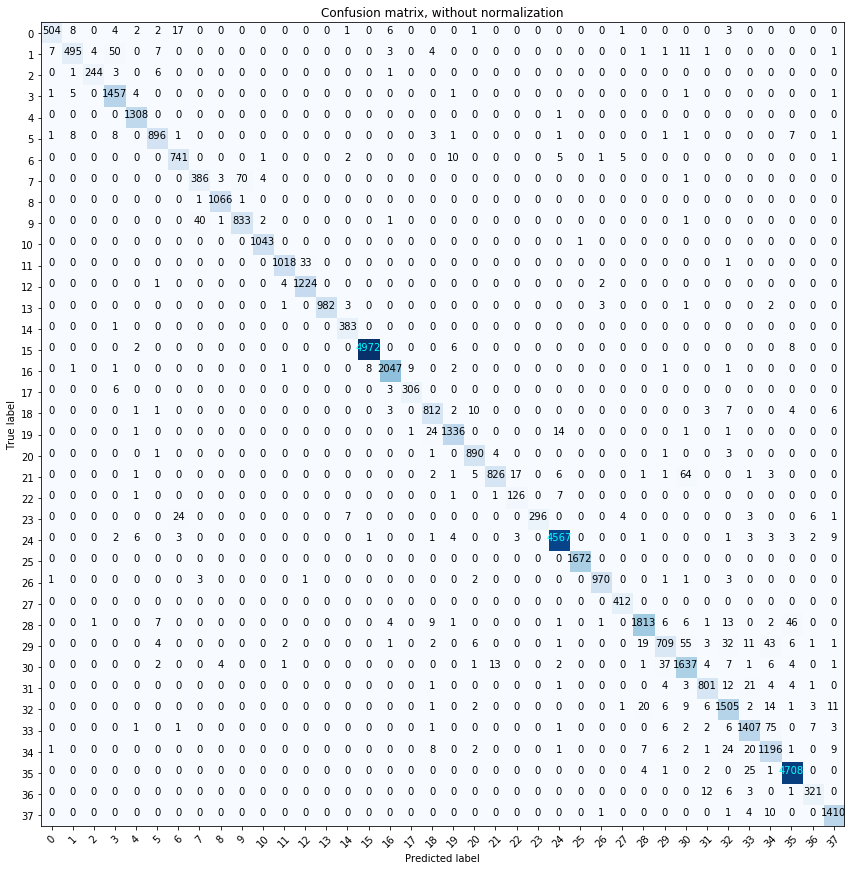

Accuracy: 0.9693
precision: 0.9695
recall: 0.9693
f1: 0.9691
precision: [0.9786 0.9556 0.9799 0.951  0.9857 0.9666 0.9416 0.8977 0.9926 0.9215
 0.9933 0.9912 0.973  1.     0.9672 0.9982 0.9894 0.9684 0.9344 0.9788
 0.9684 0.9787 0.863  1.     0.9911 0.9994 0.9918 0.974  0.9711 0.9078
 0.9115 0.9581 0.9256 0.9374 0.8801 0.9823 0.9413 0.9691]
recall: [0.918  0.8462 0.9569 0.9912 0.9992 0.9645 0.9674 0.8319 0.9981 0.9487
 0.999  0.9677 0.9943 0.9899 0.9974 0.9968 0.9884 0.9714 0.9564 0.9695
 0.9889 0.8901 0.9265 0.868  0.9909 1.     0.9878 1.     0.9487 0.7913
 0.9512 0.9401 0.9519 0.9306 0.9358 0.993  0.9359 0.9888]
fscore: [0.9474 0.8976 0.9683 0.9707 0.9924 0.9655 0.9543 0.8635 0.9953 0.9349
 0.9962 0.9793 0.9835 0.9949 0.9821 0.9975 0.9889 0.9699 0.9453 0.9741
 0.9786 0.9323 0.8936 0.9294 0.991  0.9997 0.9898 0.9868 0.9598 0.8456
 0.9309 0.9491 0.9386 0.934  0.9071 0.9876 0.9386 0.9788]
support: [ 549  585  255 1470 1309  929  766  464 1068  878 1044 1052 1231  992
  384 4988 2071  31

In [32]:
# 10/90
#preds_labels_file = args.arch + '_' + data_separate+'_'+checkpoint_fn.split('.')[0] + '.pt'
#print(preds_labels_file)
#valid_preds_labels_file = args.arch + '_' + data_separate+'_valid_'+checkpoint_fn.split('.')[0] + '.pt'
#result_prec_recall_f1(preds_labels_file, valid_preds_labels_file)

In [20]:
def get_wrong_preds_ind(bottleneck_dataset_loader, retrained_model):
    retrained_model.train(False)
    wrong_list = []
    preds_list = []
    labels_list = []
    for i, (bottleneck,_,targets) in enumerate(bottleneck_dataset_loader):
        if i == 5:
            break
        #if i == 3:
            #print(targets)
        inputv = Variable(bottleneck, volatile=True)
        targetsv = Variable(targets, volatile=True)
        if args.cuda:
            targets = targets.cuda(async=True)
        logits = retrained_model(inputv)
        _, preds = torch.max(logits.data, 1)
        compare_list = (preds == targets)
        temp_wrong_list = []
        temp_preds_list = []
        temp_labels_list = []
        for j, out in enumerate(compare_list):
            if out == 0:
                temp_wrong_list.append(j)
                temp_preds_list.append(preds[j])
                temp_labels_list.append(targets[j])
        wrong_list.append(temp_wrong_list)
        preds_list.append(temp_preds_list)
        labels_list.append(temp_labels_list)
    
    return wrong_list, preds_list, labels_list

In [21]:
wrong_list, preds_list, labels_list = get_wrong_preds_ind(leaf_test_bottleneck_loader, transfer_resnet_model)

In [22]:
# 10-90
for i in range(5):
    print(wrong_list[i])
    #print(preds_list[i])
    print(labels_list[i])

[41, 68, 74, 91]
[7, 18, 7, 7]
[19]
[9]
[26, 35, 36, 37, 38, 60]
[31, 21, 21, 21, 21, 9]
[15, 57, 79]
[7, 29, 34]
[25, 75]
[7, 33]


### The sick minus healthy

In [24]:
healthy_ind = []
for ind, cl_name in enumerate(classes):
    if cl_name.find('healthy') != -1:
        healthy_ind.append(ind)
print(healthy_ind)

[3, 4, 6, 10, 14, 17, 19, 22, 23, 24, 27, 37]


In [25]:
cl_names = []
for ind in healthy_ind:
    cl_names.append(classes[ind].replace('___healthy',''))
print(cl_names)

['Apple', 'Blueberry', 'Cherry_including_sour', 'Corn_maize', 'Grape', 'Peach', 'Pepper_bell', 'Potato', 'Raspberry', 'Soybean', 'Strawberry', 'Tomato']


In [26]:
cla_ind_to_healthy_cla_index = {}
for ind, cl_name in enumerate(classes):
    flag=0
    for ki, kind in enumerate(cl_names):
        if cl_name.find(kind) != -1:
            cla_ind_to_healthy_cla_index[ind] = healthy_ind[ki]
            flag=1
            break
    if flag==0:
        cla_ind_to_healthy_cla_index[ind] = -1
cla_ind_to_healthy_cla_index

{0: 3,
 1: 3,
 2: 3,
 3: 3,
 4: 4,
 5: 6,
 6: 6,
 7: 10,
 8: 10,
 9: 10,
 10: 10,
 11: 14,
 12: 14,
 13: 14,
 14: 14,
 15: -1,
 16: 17,
 17: 17,
 18: 19,
 19: 19,
 20: 22,
 21: 22,
 22: 22,
 23: 23,
 24: 24,
 25: -1,
 26: 27,
 27: 27,
 28: 37,
 29: 37,
 30: 37,
 31: 37,
 32: 37,
 33: 37,
 34: 37,
 35: 37,
 36: 37,
 37: 37}